#### Importing Modules

In [1]:
%%time
from __future__ import print_function, division, unicode_literals, absolute_import

import os
os.environ["PYTHONHASHSEED"] = str(1)

import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
               rc={"lines.linewidth": 2.5})

from sklearn.model_selection import train_test_split

import warnings 
warnings.filterwarnings("ignore")

%reload_ext tensorboard
import time

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D

random.seed(1)
np.random.seed(1)

Wall time: 6.18 s


#### Loading Fashion MNIST Dataset

In [2]:
import util_mnist_reader
X_train, y_train = util_mnist_reader.load_mnist("data/fashion/", kind='train')
X_test, y_test = util_mnist_reader.load_mnist("data/fashion/", kind='t10k')

#### Normalizing the data using min-max scalar

In [3]:
X_train, X_test = X_train/255., X_test/255.

In [4]:
X_train, X_test = X_train.reshape(-1, 28*28), X_test.reshape(-1, 28*28)

#### Defining the labels

In [5]:
labels = [ "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal",	"Shirt", "Sneaker", "Bag", "Ankle boot"]

#### Spltting data into train and validation

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

#### Defining the helper functions

In [7]:
def forward(X, W1, b1, W2, b2):
    Z = np.tanh(X.dot(W1) + b1)
    A = Z.dot(W2) + b2
    expA = np.exp(A)
    Y = expA / expA.sum(axis=1, keepdims=True)
    return Y, Z

def classification_rate(Y, P):
    n_correct = 0
    n_total = 0
    for i in range(len(Y)):
        n_total += 1
        if Y[i] == P[i]:
            n_correct += 1
    return float(n_correct) / n_total


def derivative_w2(Z, T, Y):
    N, K = T.shape
    M = Z.shape[1] 
    ret4 = Z.T.dot(T - Y)
    return ret4


def derivative_w1(X, Z, T, Y, W2):
    N, D = X.shape
    M, K = W2.shape
    dZ = (T - Y).dot(W2.T) * (1 - np.power(Z, 2))
    ret2 = X.T.dot(dZ)
    return ret2


def derivative_b2(T, Y):
    return (T - Y).sum(axis=0)


def derivative_b1(T, Y, W2, Z):
    return ((T - Y).dot(W2.T) * (1 - np.power(Z, 2))).sum(axis=0)


def cost(T, Y):
    m = T.shape[0]
    #tot = (T * np.log(Y) 
    tot= - (1/ m)*(np.multiply(T, np.log(Y)))
                             
    return np.sum(tot)

#### Visualizing the Fashion MNIST Dataset

In [8]:
def vizualize_fmnist(X, y):
    X = X.reshape(-1,28,28)
    plt.figure(figsize=(20,18))    
    for e in range(36):
        plt.subplot(6, 6, e+1)
        idx = random.randint(0, len(y))
        plt.imshow(X[idx, :, :], cmap="gray", interpolation="nearest")
        plt.grid(True)
        plt.xticks([])
        plt.yticks([])
        plt.title(labels[y[idx]],fontsize=14)
    plt.suptitle("Fashion MNIST Dataset",fontsize=15)
    plt.show()

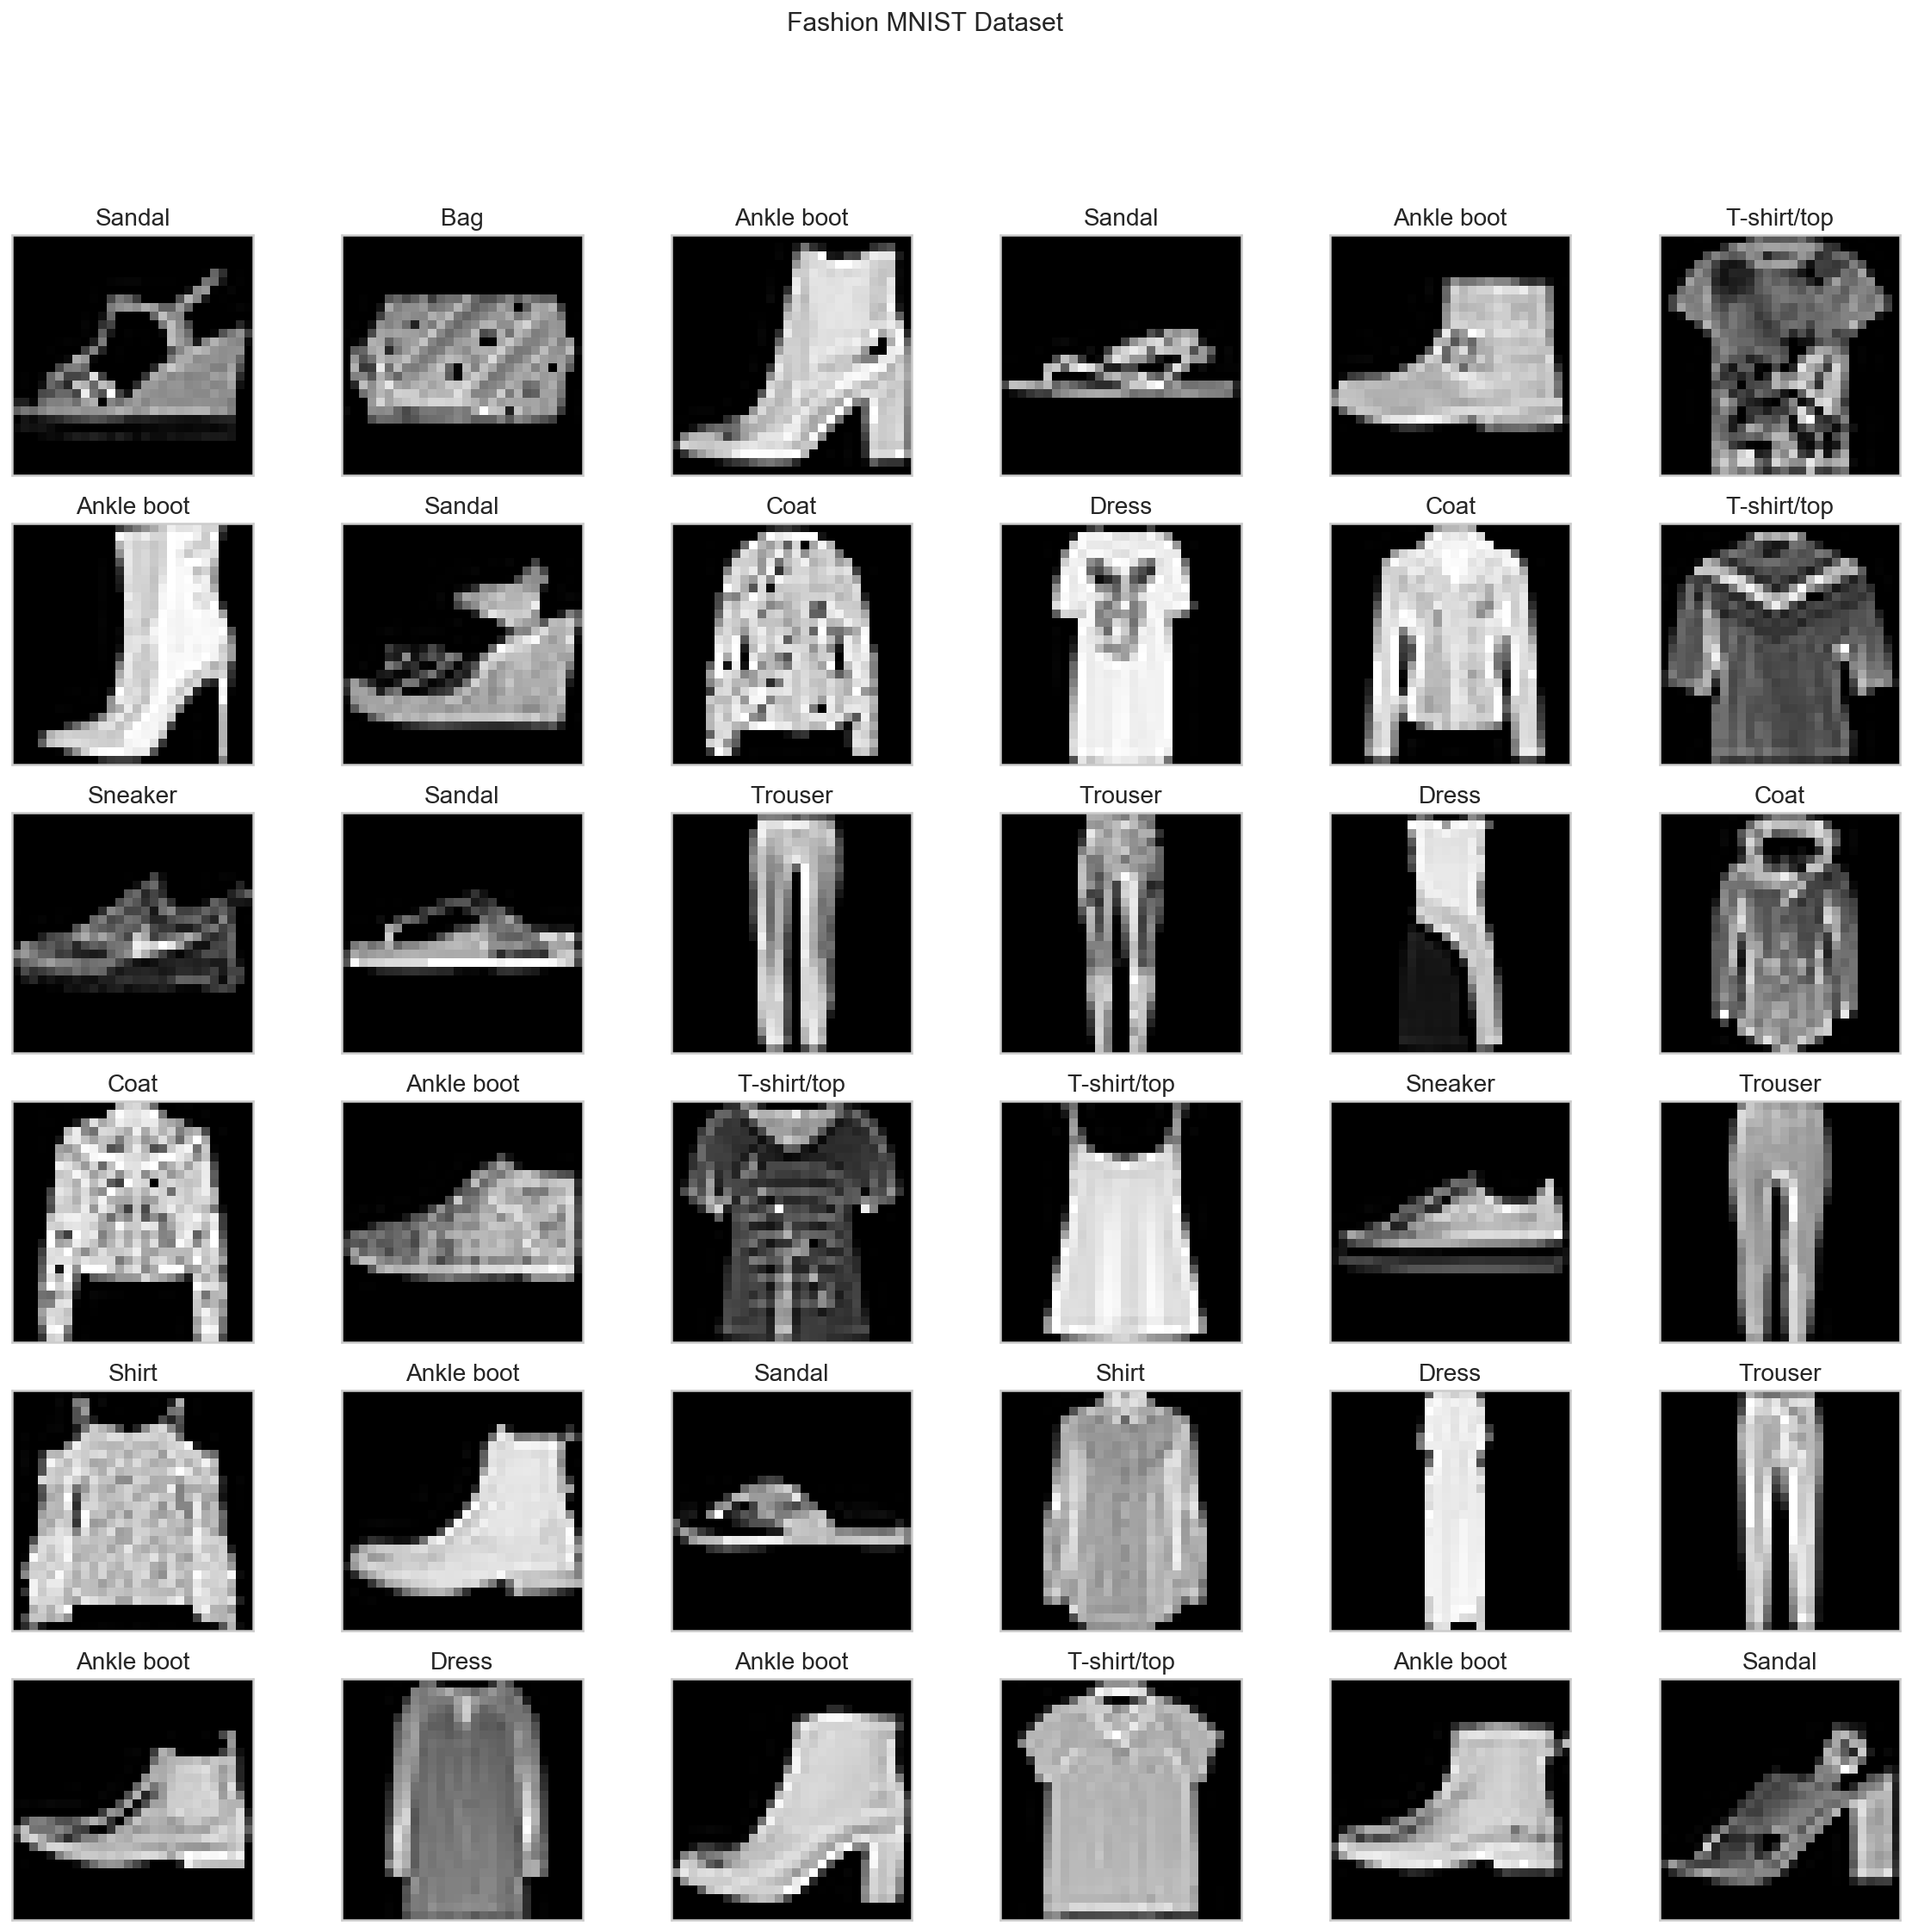

In [9]:
vizualize_fmnist(X_train, y_train)

#### Checking the dimension of Train, Test and Validation Data

In [10]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)

(48000, 784)
(48000,)
(10000, 784)
(10000,)
(12000, 784)


In [11]:
def vizualize_loss_accuracy(training_dict):
    training_keys = list(training_dict.keys())
    plt.figure(figsize=(18,16))
    for idx in range(len(training_keys)):
        plt.subplot(2,2,1)
        plt.plot(training_dict[training_keys[idx]][0], label = f"Hidden neurons {training_keys[idx]}")
        plt.legend()
        plt.xlabel("Epochs")
        plt.ylabel("Training Loss")

        plt.subplot(2,2,2)
        plt.plot(training_dict[training_keys[idx]][1], label = f"Hidden neurons {training_keys[idx]}")
        plt.legend()
        plt.xlabel("Epochs")
        plt.ylabel("Validation Loss")

        plt.subplot(2,2,3)
        plt.plot(training_dict[training_keys[idx]][2], label = f"Hidden neurons {training_keys[idx]}")
        plt.legend()
        plt.xlabel("Epochs")
        plt.ylabel("Training Accuracy")

        plt.subplot(2,2,4)
        plt.plot(training_dict[training_keys[idx]][3], label = f"Hidden neurons {training_keys[idx]}")
        plt.legend()
        plt.xlabel("Epochs")
        plt.ylabel("Validation Accuracy")

        plt.tight_layout()

#### Training the Single Neural Network

In [12]:
def main(X_train, y_train, X_val, y_val):
    D = 784 
    size = [10, 20, 30, 40] 
    K = 10 

    X = X_train[:20000, :]
    Y = y_train[:20000]
    
    #X = X_train
    #Y = y_train
    
    N = len(Y)
    N_val = len(y_val)
    
    T = np.zeros((N, K))
    T_val = np.zeros((N_val, K))
    
    for i in range(N):
        T[i, Y[i]] = 1
    
    for i in range(N_val):
        T_val[i, y_val[i]] = 1

    learning_rate = 1e-4
    

    training_dict = {}
    parameters_dict = {}    

    for M in size:
        W1 = np.random.randn(D, M)
        b1 = np.random.randn(M)
        W2 = np.random.randn(M, K)
        b2 = np.random.randn(K)

        train_costs = []
        validation_costs = []
        train_accuracy = []
        validation_accuracy = []
        
        print(f"\nTraining with {M} number of hidden nodes.")
        
        for epoch in range(0,1000+1):
            output, hidden = forward(X, W1, b1, W2, b2)
            if epoch % 10 == 0:
                
                c = cost(T, output)
                P = np.argmax(output, axis=1)
                r = classification_rate(Y, P)
                
                train_accuracy.append(r)
                train_costs.append(c)
                
                output_val, hidden_val = forward(X_val, W1, b1, W2, b2)
                c_val = cost(T_val, output_val)
                validation_costs.append(c_val)
                predictions_val = np.argmax(output_val, axis=1)
                r_val = classification_rate(y_val, predictions_val)
                validation_accuracy.append(r_val)
                
                if epoch % 100 == 0:
                    print("Training Cost {:.3f} : Training Accuracy {:.2f}% : Validation Cost {:.3f} : Validation Accuracy {:.2f}%".format(c, r*100, c_val, r_val*100))
 
            W2 += learning_rate * derivative_w2(hidden, T, output)
            b2 += learning_rate * derivative_b2(T, output)
            W1 += learning_rate * derivative_w1(X, hidden, T, output, W2)
            b1 += learning_rate * derivative_b1(T, output, W2, hidden)

        parameters_dict[M] = {
            "W2":W2,
            "b2":b2,
            "W1":W1,
            "b1":b1
        }
        
        training_dict[M] = (train_costs, validation_costs, train_accuracy, validation_accuracy)

    return parameters_dict, training_dict

In [13]:
if __name__ == '__main__':
    parameters_dict, training_dict = main(X_train, y_train, X_val, y_val)


Training with 10 number of hidden nodes.
Training Cost 7.624 : Training Accuracy 3.32% : Validation Cost 7.621 : Validation Accuracy 3.60%
Training Cost 1.017 : Training Accuracy 60.72% : Validation Cost 1.025 : Validation Accuracy 60.25%
Training Cost 0.885 : Training Accuracy 67.77% : Validation Cost 0.907 : Validation Accuracy 66.88%
Training Cost 0.794 : Training Accuracy 72.26% : Validation Cost 0.827 : Validation Accuracy 71.38%
Training Cost 0.740 : Training Accuracy 74.28% : Validation Cost 0.782 : Validation Accuracy 72.97%
Training Cost 0.707 : Training Accuracy 75.19% : Validation Cost 0.754 : Validation Accuracy 73.71%
Training Cost 0.684 : Training Accuracy 76.08% : Validation Cost 0.736 : Validation Accuracy 74.48%
Training Cost 0.664 : Training Accuracy 76.77% : Validation Cost 0.722 : Validation Accuracy 75.09%
Training Cost 0.650 : Training Accuracy 77.23% : Validation Cost 0.713 : Validation Accuracy 75.37%
Training Cost 0.635 : Training Accuracy 77.74% : Validation 

#### Visualizing the Training Loss, Validation Loss, Training Accuracy, Validation Accuracy

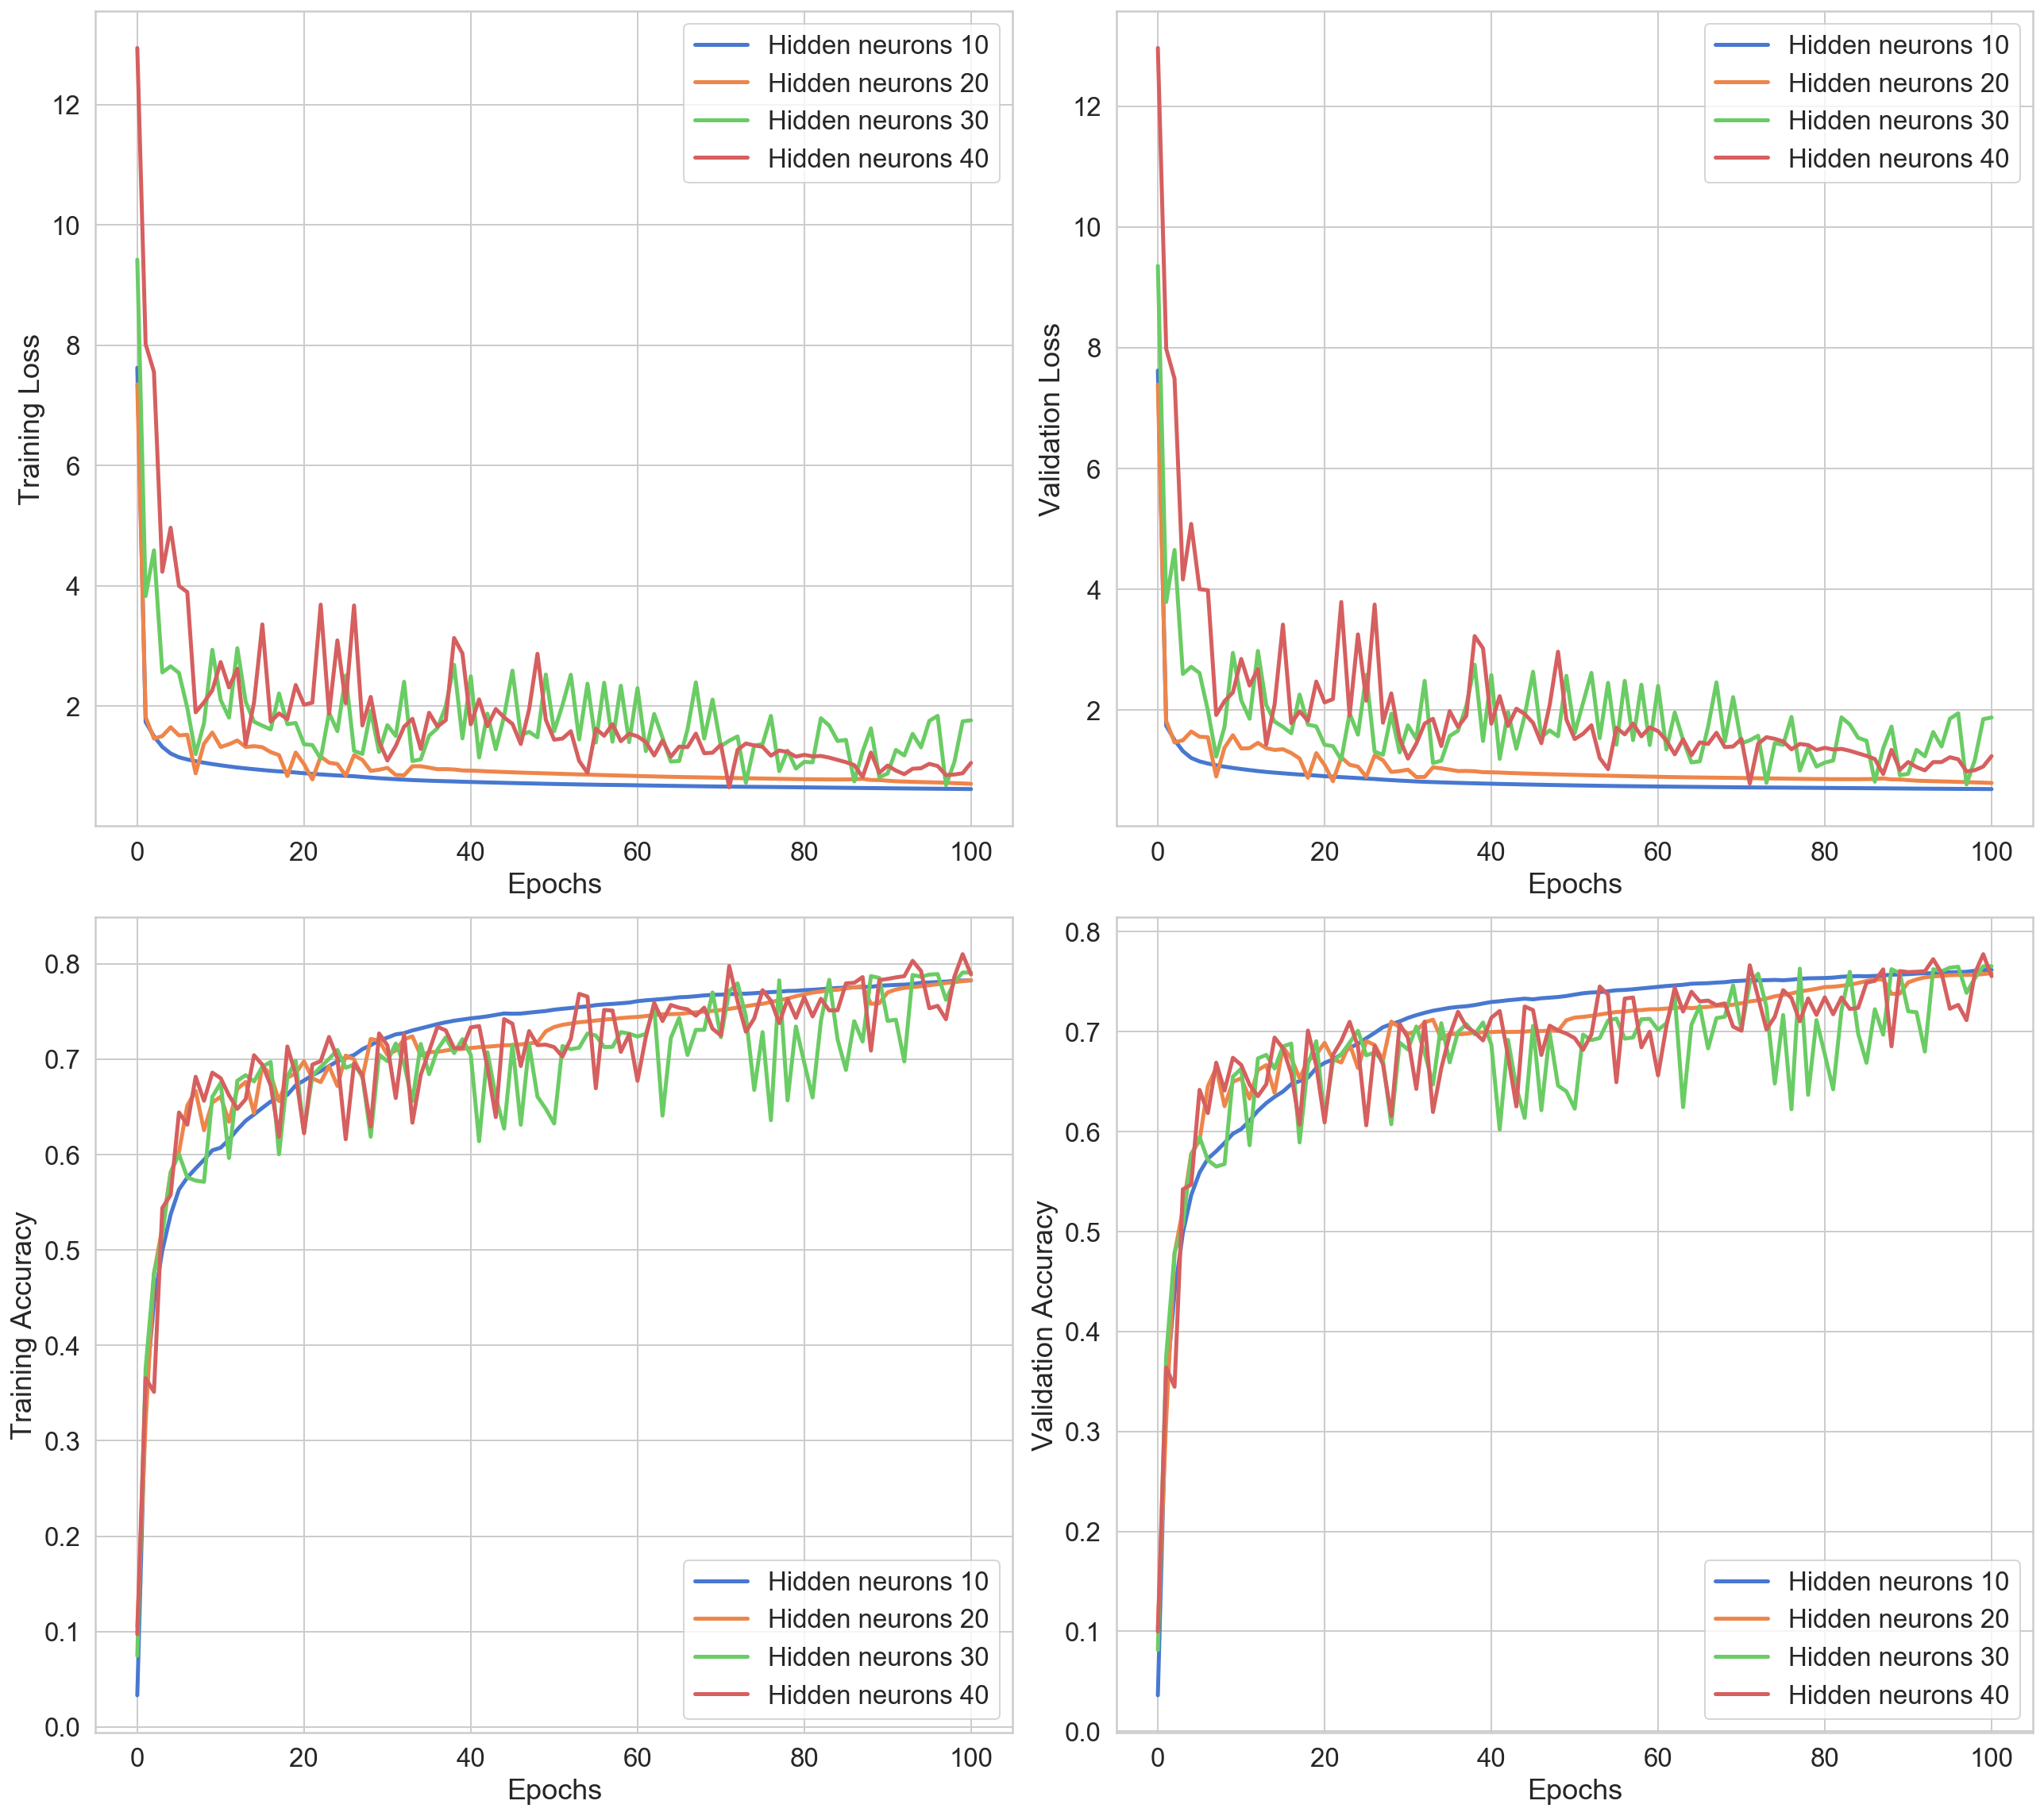

In [14]:
vizualize_loss_accuracy(training_dict)

### Inference

#### Loading the Test Data

In [15]:
print(X_test.shape)

(10000, 784)


#### Recalling the Trained Parameters

In [16]:
W1 = parameters_dict[40]["W1"]
b1 = parameters_dict[40]["b1"]
W2 = parameters_dict[40]["W2"]
b2 = parameters_dict[40]["b2"]

#### Predicting through Forward Neural Network

In [17]:
output, hidden = forward(X_test, W1, b1, W2, b2)

In [18]:
predictions = np.argmax(output, axis=1)

#### Plotting the Predictions

In [19]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    plt.xlabel("{} {:2.0f}% ({})".format(labels[predicted_label],
                                100*np.max(predictions_array),
                                labels[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

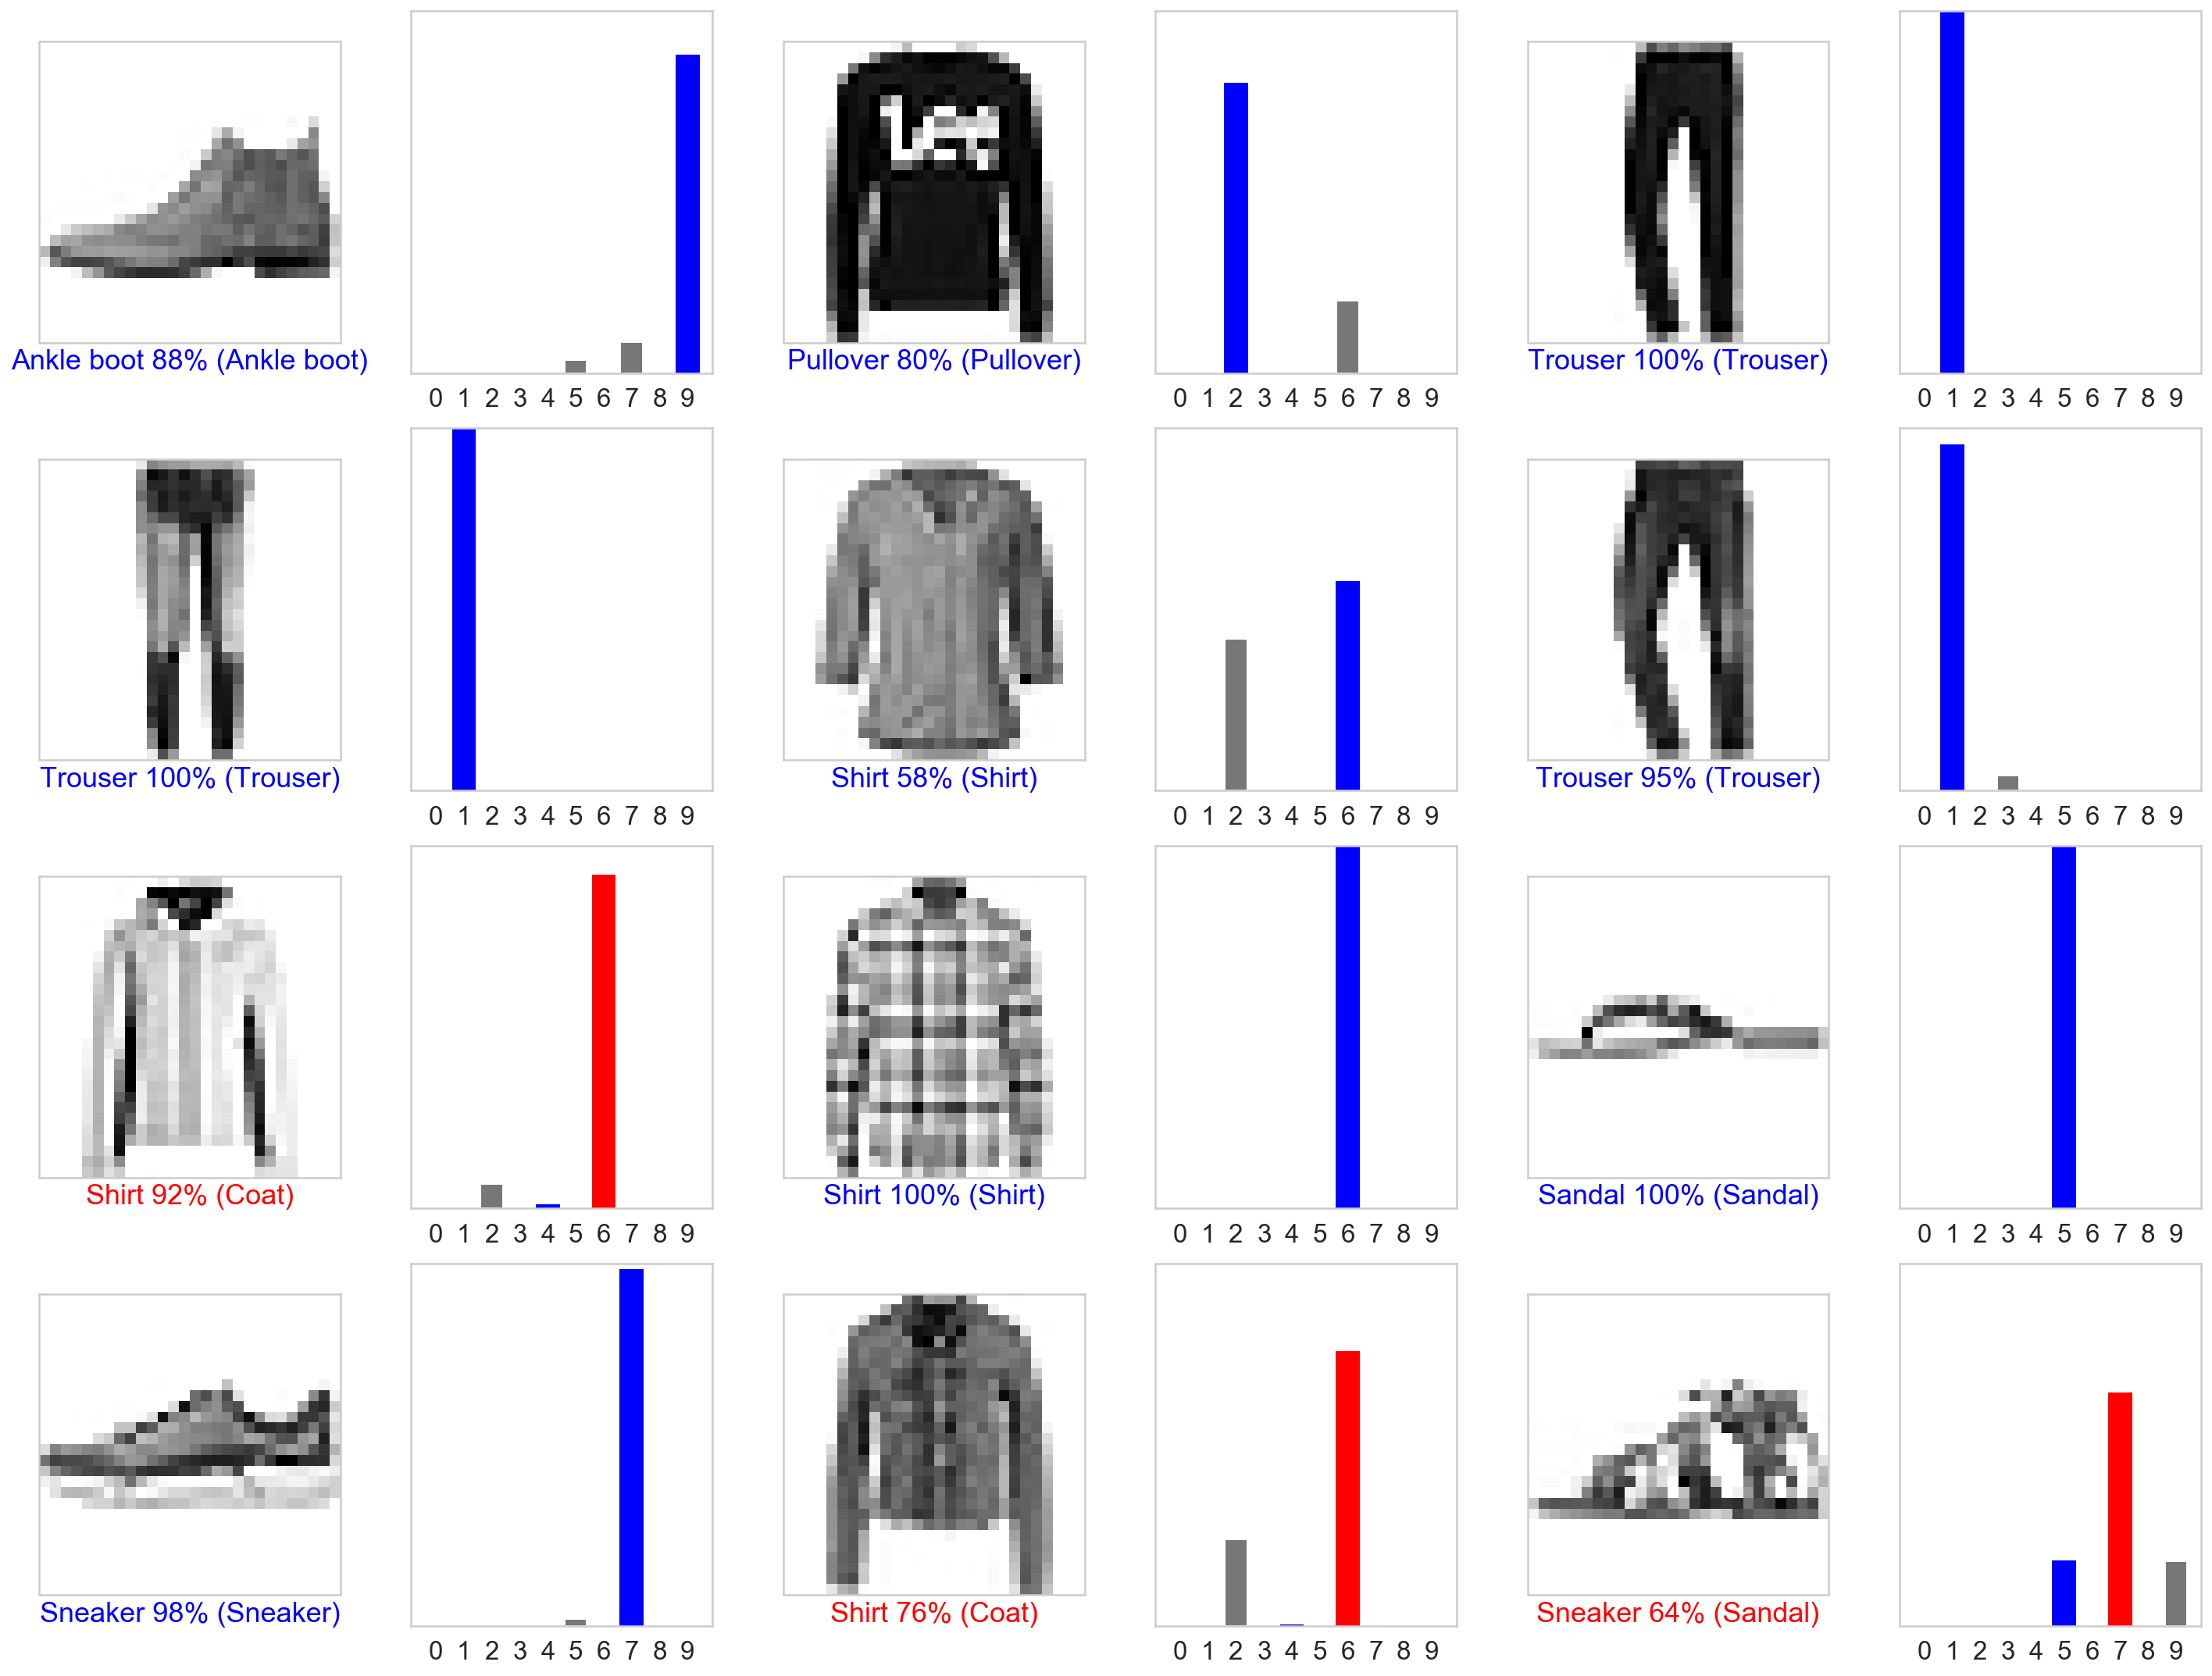

In [20]:
num_rows = 4
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(20, 15))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, output[i], y_test, X_test.reshape(-1, 28, 28))
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, output[i], y_test)
plt.tight_layout()
plt.show()

#### Classification Accuracy

In [21]:
P = np.argmax(output, axis=1)
print(f"The accuracy of Shallow Neural Network with 40 hidden nodes is {np.round(classification_rate(y_test, P)*100)}%")

The accuracy of Shallow Neural Network with 40 hidden nodes is 69.0%


#### Plotting and analyzing other Metrics

#### Confusion Matrix

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 <a list of 10 Text yticklabel objects>)

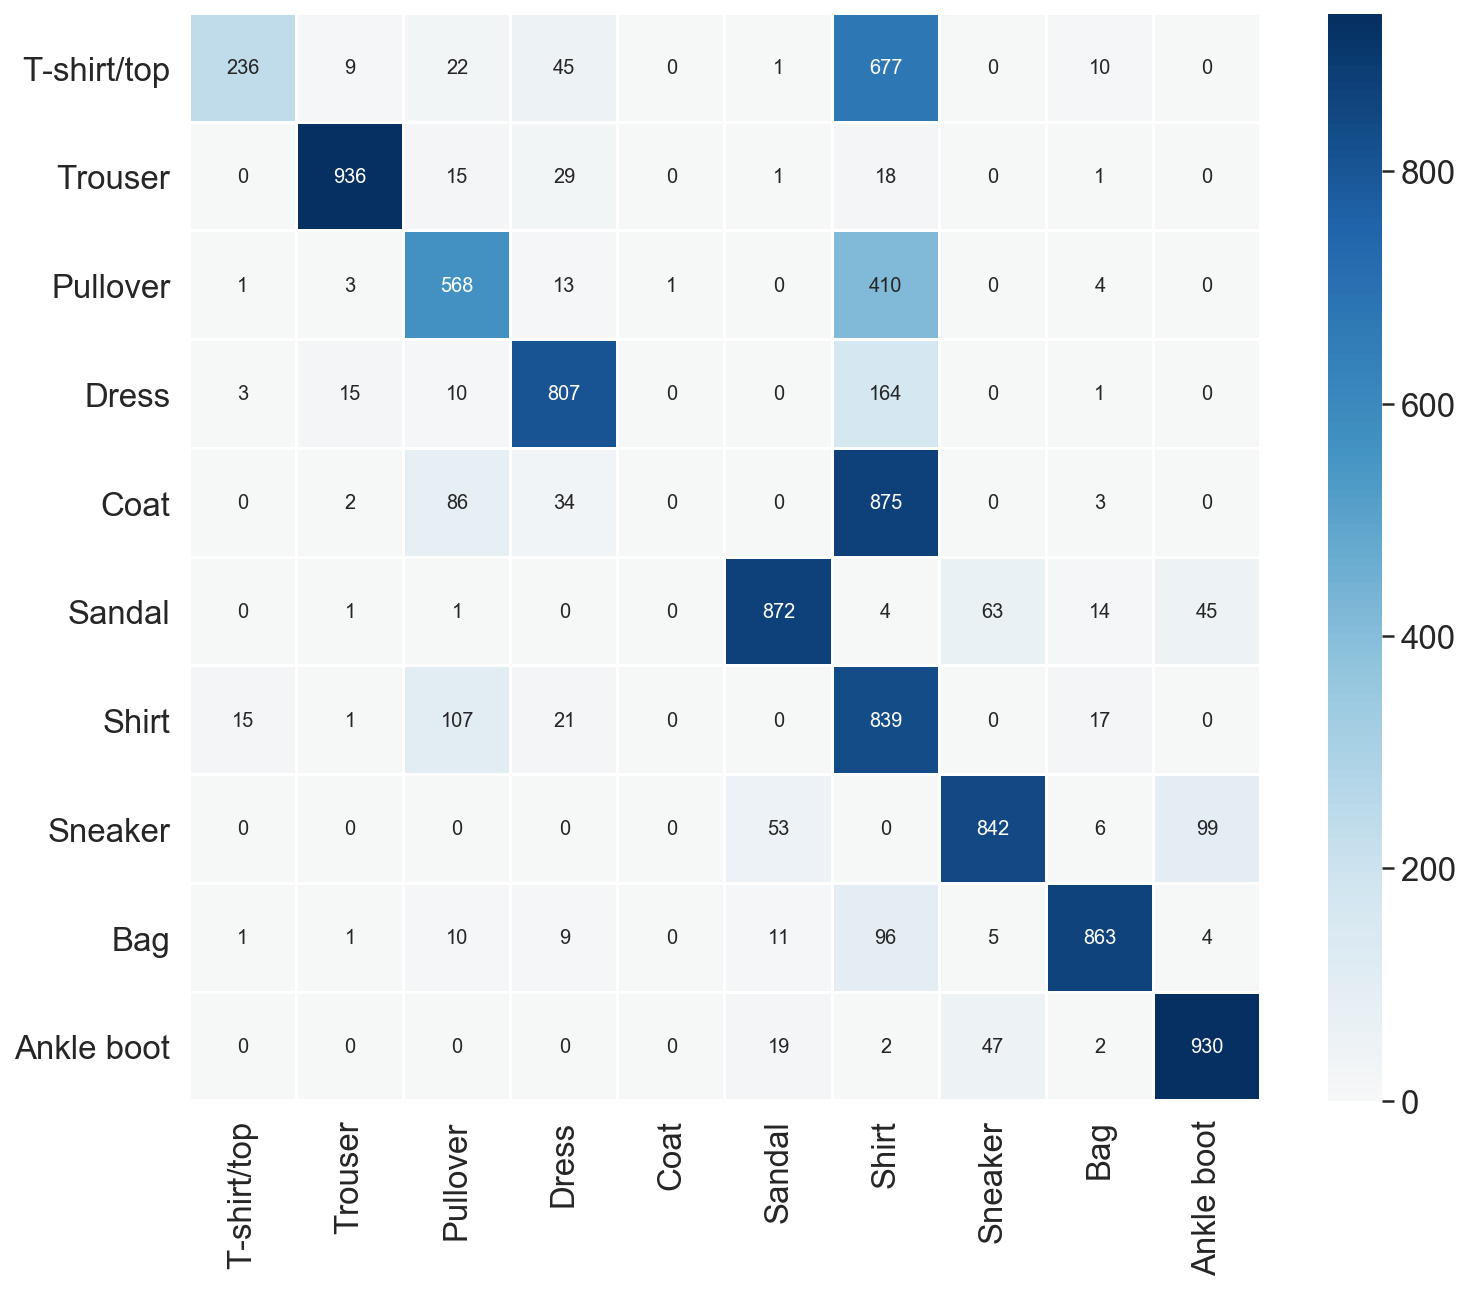

In [22]:
from sklearn.metrics import *
cm = confusion_matrix(y_test, P)
plt.figure(figsize=(12,10))
sns.heatmap(cm, center=0, annot=True, fmt=".0f",linewidths=1, cmap="RdBu",xticklabels=labels,yticklabels=labels)
plt.xticks(rotation=90)
plt.yticks(rotation=0)

#### Calculating the value of Precision, Recall, Accuracy and F1 score

In [23]:
print(classification_report(y_test, P, labels=np.unique(y_test).sort()))

              precision    recall  f1-score   support

           0       0.92      0.24      0.38      1000
           1       0.97      0.94      0.95      1000
           2       0.69      0.57      0.62      1000
           3       0.84      0.81      0.82      1000
           4       0.00      0.00      0.00      1000
           5       0.91      0.87      0.89      1000
           6       0.27      0.84      0.41      1000
           7       0.88      0.84      0.86      1000
           8       0.94      0.86      0.90      1000
           9       0.86      0.93      0.90      1000

    accuracy                           0.69     10000
   macro avg       0.73      0.69      0.67     10000
weighted avg       0.73      0.69      0.67     10000



### Deep Neural Network

In [24]:
X_train, X_test, X_val = X_train.reshape(-1, 28, 28), X_test.reshape(-1, 28, 28), X_val.reshape(-1, 28, 28)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(48000, 28, 28)
(10000, 28, 28)
(12000, 28, 28)


#### Declaring the hyperparameters

In [25]:
import time
dense_layers = [1,2]
layer_sizes = [32,64]

#### Training the Deep Neural Network

In [26]:
histories = {}
for dense_layer in dense_layers:
    for layer_size in layer_sizes:
            model_ckeckpoint = tf.keras.callbacks.ModelCheckpoint(filepath="{}-nodes-{}-dense.h5".format(layer_size, dense_layer), monitor="val_loss",verbose=1,save_best_only=True, save_weights_only=True)
            model = Sequential()
            model.add(Dense(layer_size, input_shape = X_train.shape[1:]))
            model.add(Activation("relu"))
            for l in range(dense_layer):
                model.add(Dense(layer_size))
                model.add(Activation("relu"))
            model.add(Flatten())
            model.add(Dense(10))
            model.add(Activation(activation="softmax"))
            model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics = ["accuracy"])
            history = model.fit(X_train,y_train,batch_size=2048,validation_data=(X_val, y_val),epochs=10, callbacks=[model_ckeckpoint])
            histories["{}-nodes-{}-dense".format(layer_size, dense_layer)] = history

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
47104/48000 [============================>.] - ETA: 0s - loss: 1.8638 - accuracy: 0.4162
Epoch 00001: val_loss improved from inf to 1.31438, saving model to 32-nodes-1-dense.h5
48000/48000 [==============================] - 4s 85us/sample - loss: 1.8548 - accuracy: 0.4207 - val_loss: 1.3144 - val_accuracy: 0.6889
Epoch 2/10
47104/48000 [============================>.] - ETA: 0s - loss: 0.9893 - accuracy: 0.7227
Epoch 00002: val_loss improved from 1.31438 to 0.74593, saving model to 32-nodes-1-dense.h5
48000/48000 [==============================] - 2s 32us/sample - loss: 0.9844 - accuracy: 0.7236 - val_loss: 0.7459 - val_accuracy: 0.7549
Epoch 3/10
47104/48000 [============================>.] - ETA: 0s - loss: 0.6722 - accuracy: 0.7718
Epoch 00003: val_loss improved from 0.74593 to 0.61713, saving model to 32-nodes-1-dense.h5
48000/48000 [==============================] - 1s 26us/sample - loss: 0.6712 - accuracy: 0.7718 - val_

Epoch 6/10
47104/48000 [============================>.] - ETA: 0s - loss: 0.4830 - accuracy: 0.8305
Epoch 00006: val_loss improved from 0.50172 to 0.47485, saving model to 32-nodes-2-dense.h5
48000/48000 [==============================] - 2s 34us/sample - loss: 0.4827 - accuracy: 0.8306 - val_loss: 0.4749 - val_accuracy: 0.8335
Epoch 7/10
45056/48000 [===========================>..] - ETA: 0s - loss: 0.4570 - accuracy: 0.8397
Epoch 00007: val_loss improved from 0.47485 to 0.45432, saving model to 32-nodes-2-dense.h5
48000/48000 [==============================] - 2s 41us/sample - loss: 0.4575 - accuracy: 0.8396 - val_loss: 0.4543 - val_accuracy: 0.8407
Epoch 8/10
47104/48000 [============================>.] - ETA: 0s - loss: 0.4395 - accuracy: 0.8466
Epoch 00008: val_loss improved from 0.45432 to 0.43932, saving model to 32-nodes-2-dense.h5
48000/48000 [==============================] - 2s 42us/sample - loss: 0.4396 - accuracy: 0.8466 - val_loss: 0.4393 - val_accuracy: 0.8468
Epoch 9/10

#### Visualizing the Training Loss, Validation Loss, Training Accuracy, Validation Accuracy

In [27]:
def plot_histories(history, key):    
    plt.subplot(121)
    g = plt.plot(history.epoch, history.history["loss"], label=key, marker='o')
    plt.plot(history.epoch, history.history["val_loss"], "--", marker='o', c= g[0].get_color())
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.suptitle("Training and Validation Loss")
    plt.grid(True)
    plt.legend()

    plt.subplot(122)
    g = plt.plot(history.epoch, history.history["accuracy"], label=key, marker='o')
    plt.plot(history.epoch, history.history["val_accuracy"], "--", marker='o', c= g[0].get_color())
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.suptitle("Training and Validation Accuracy")
    plt.grid(True)
    plt.legend()

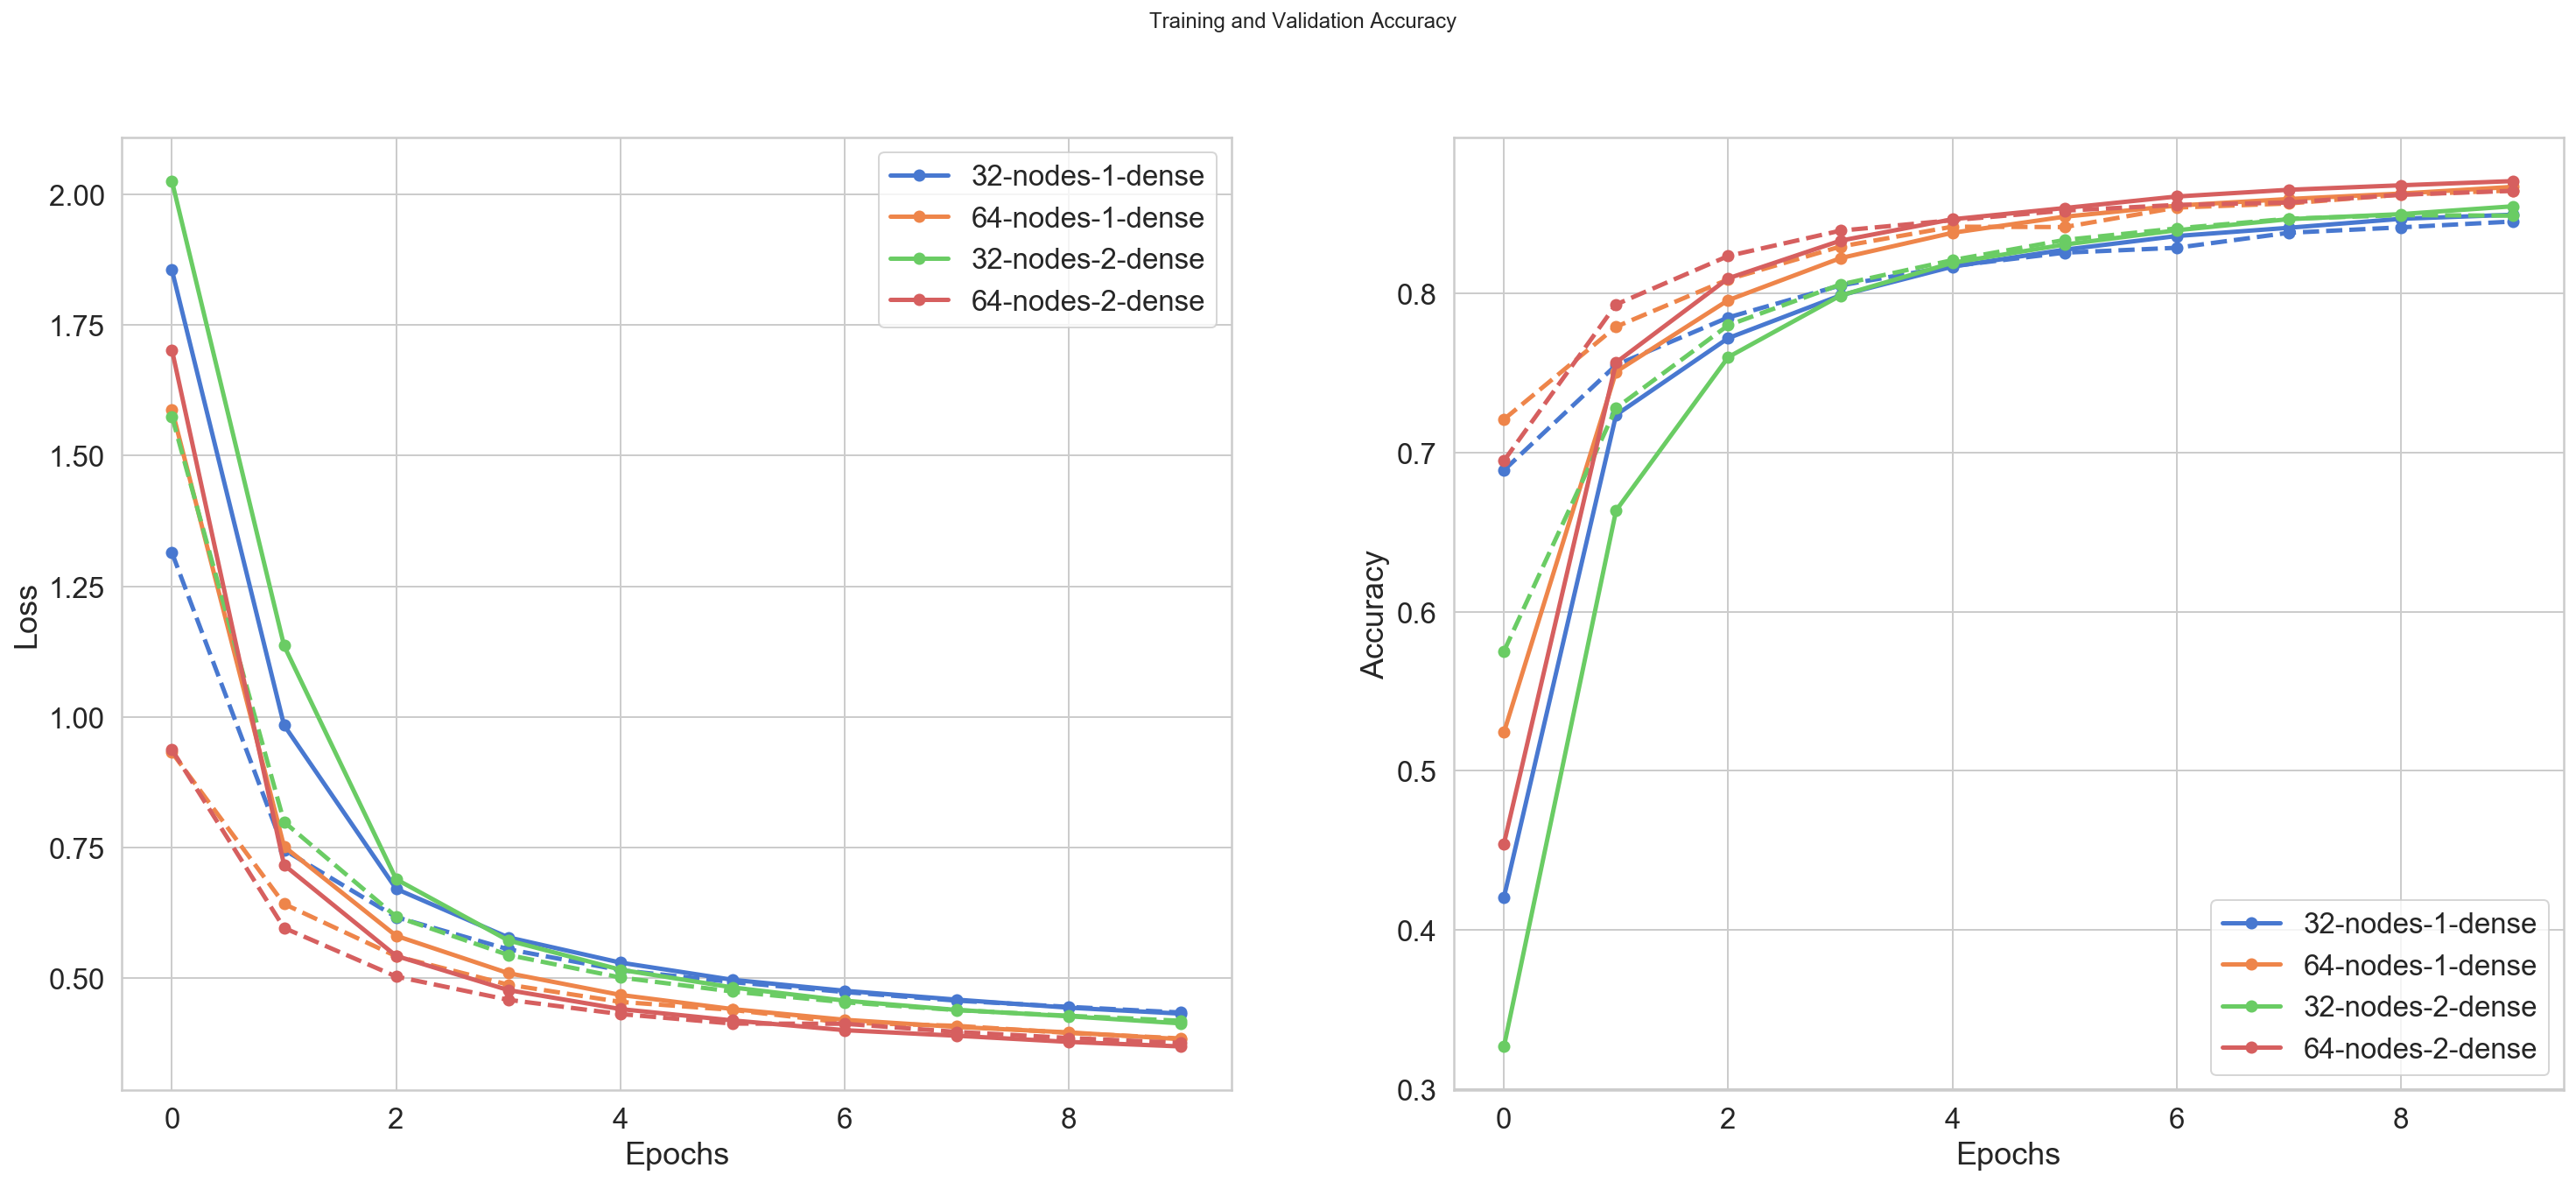

In [28]:
key = list(histories.keys())
plt.figure(figsize=(25,10))
for i in key:
    plot_histories(histories[i],i)

#### Choosing the best model

In [29]:
max_val_accuracy = 0
model_name = None
for i in key:
    if histories[i].history["val_accuracy"][-1] > max_val_accuracy:
        max_val_acc = histories[i].history["val_accuracy"][-1]
        model_name = i

In [30]:
print(f"The best hyperparameters are: {model_name}")

The best hyperparameters are: 64-nodes-2-dense


In [31]:
model.load_weights(f"{model_name}.h5")

#### Loading the Test Data

In [32]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0, batch_size=1024)

In [33]:
for name, value in zip(model.metrics_names, (loss, accuracy)):
    print(name, ":", value)

loss : 0.40353490200042724
accuracy : 0.858


In [34]:
pred = model.predict(X_test)

In [35]:
predictions = np.argmax(pred, axis=1)

#### Plotting the Predictions

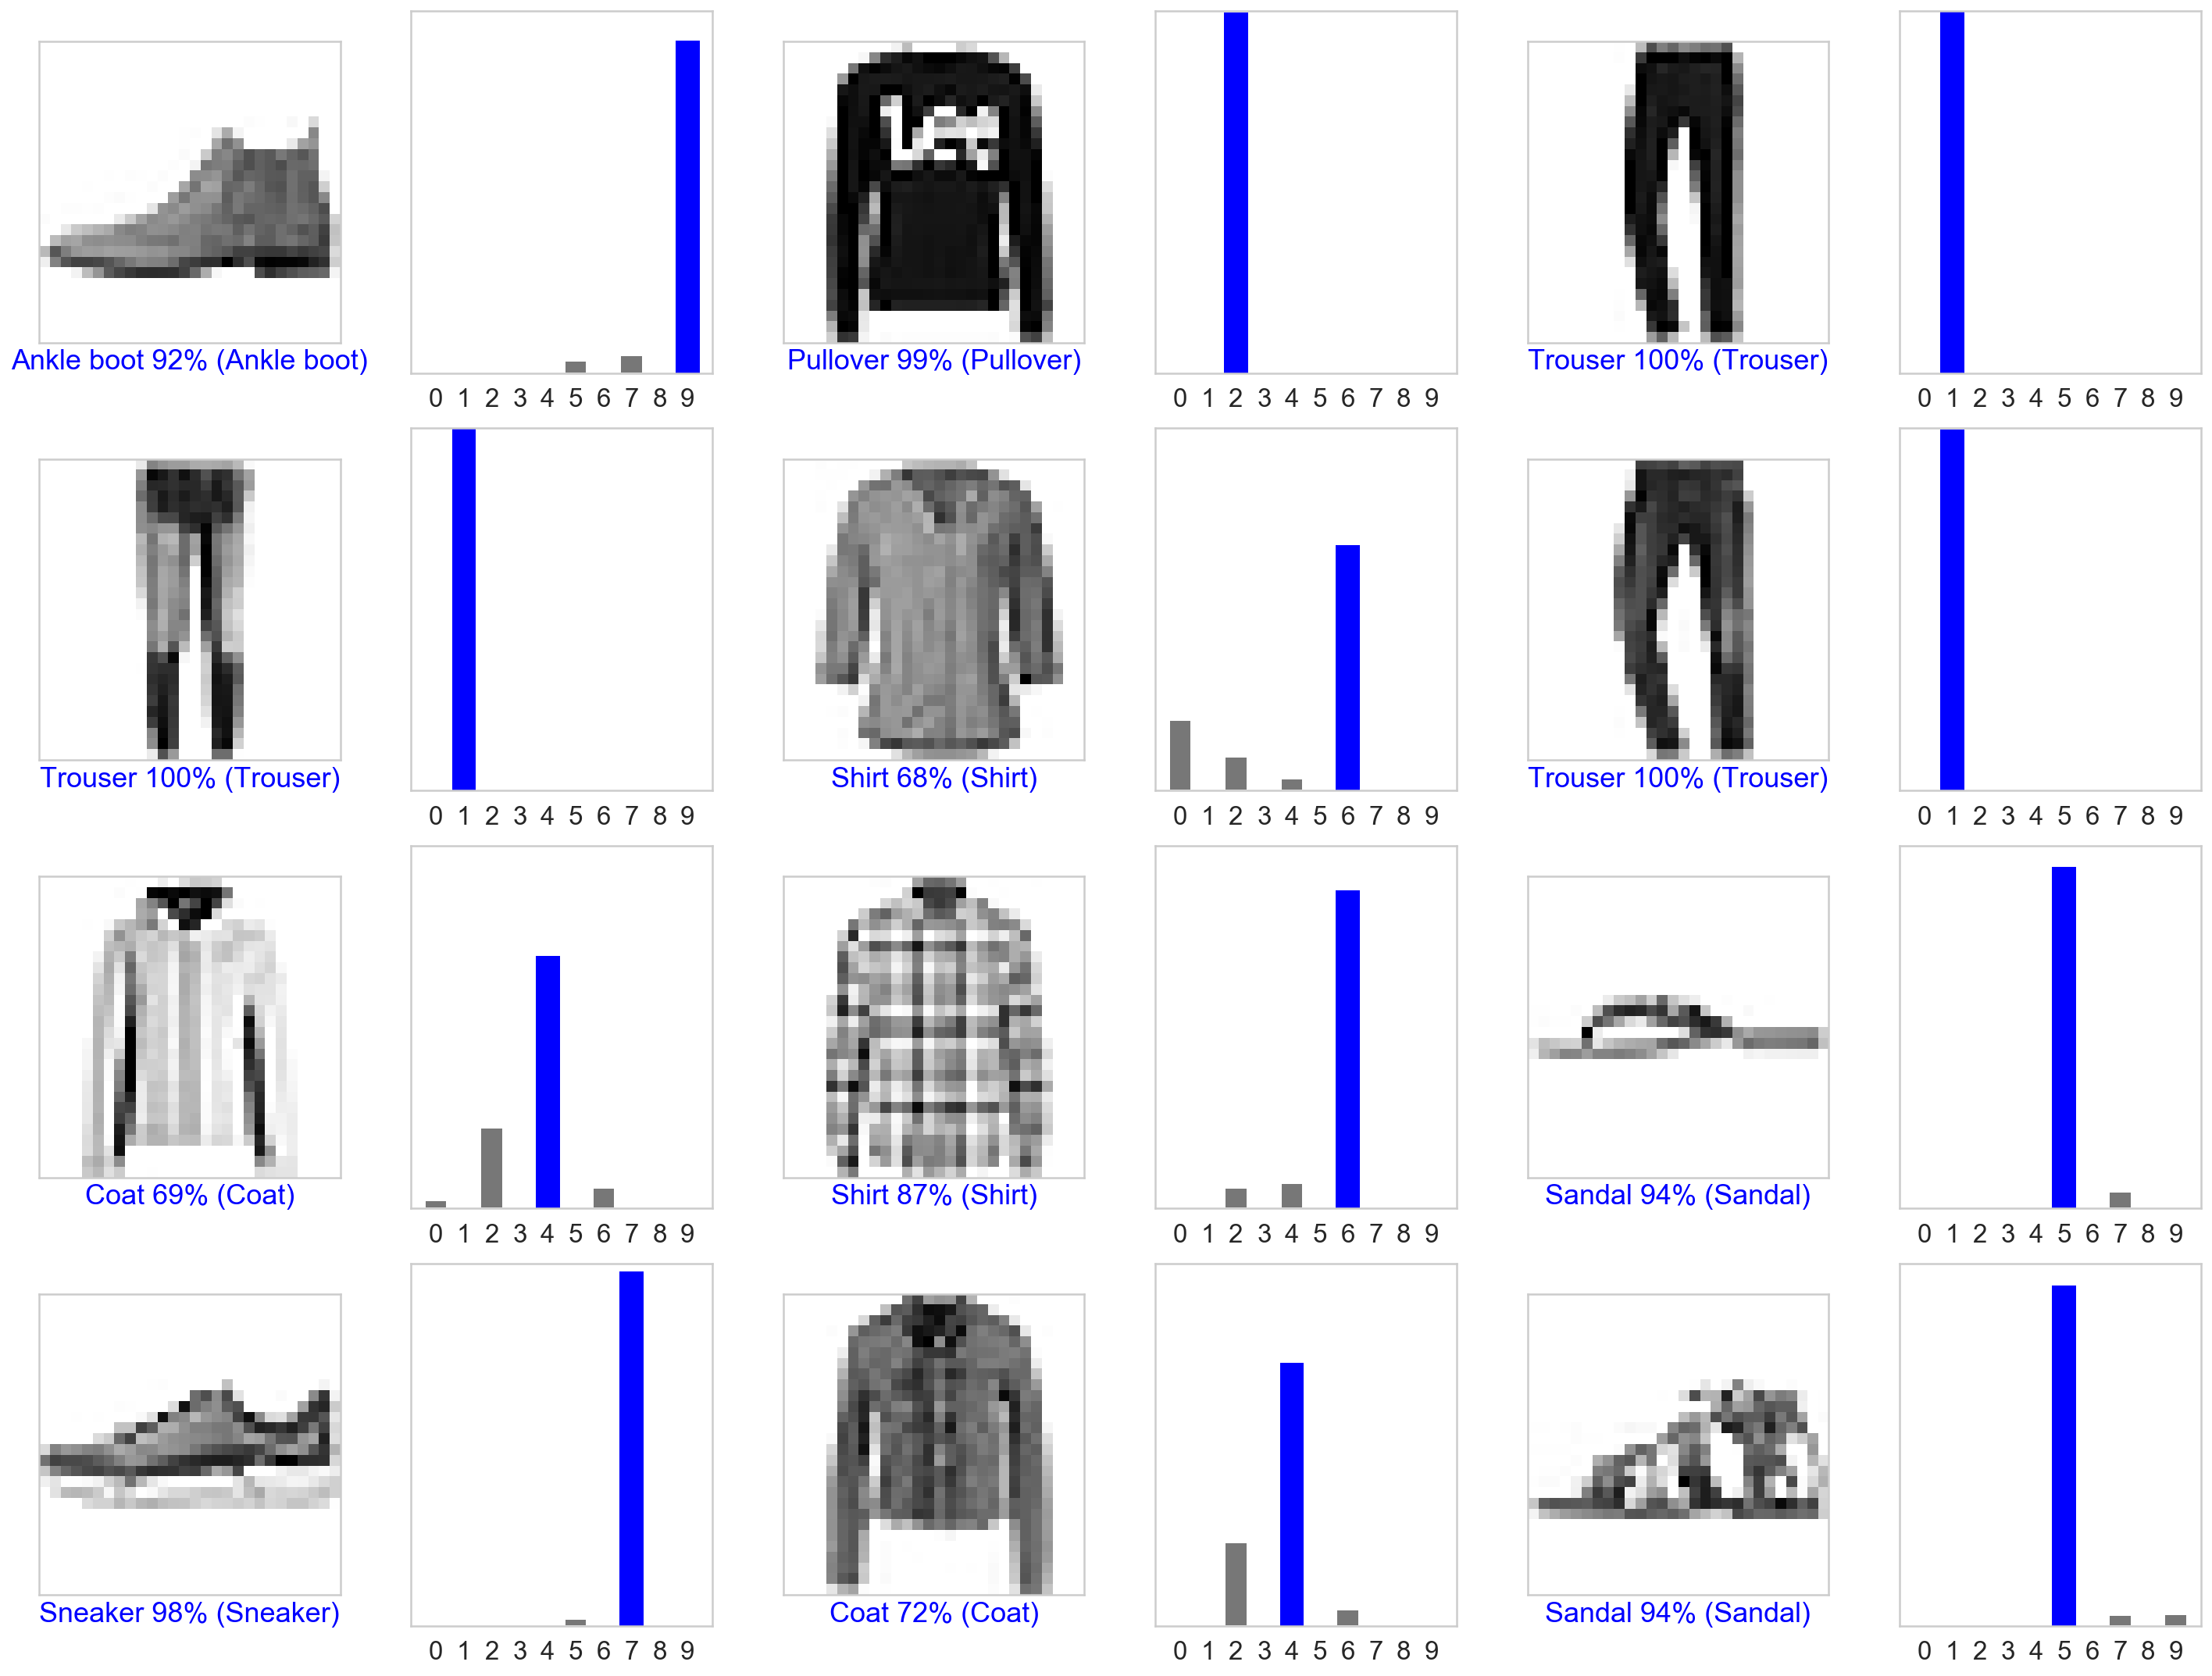

In [36]:
num_rows = 4
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(20, 15))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, pred[i], y_test, X_test.reshape(-1, 28, 28))
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, pred[i], y_test)
plt.tight_layout()
plt.show()

#### Classification Accuracy

In [37]:
print(f"The accuracy of the model is: {accuracy_score(predictions, y_test)*100}%")

The accuracy of the model is: 85.8%


#### Confusion Matrix

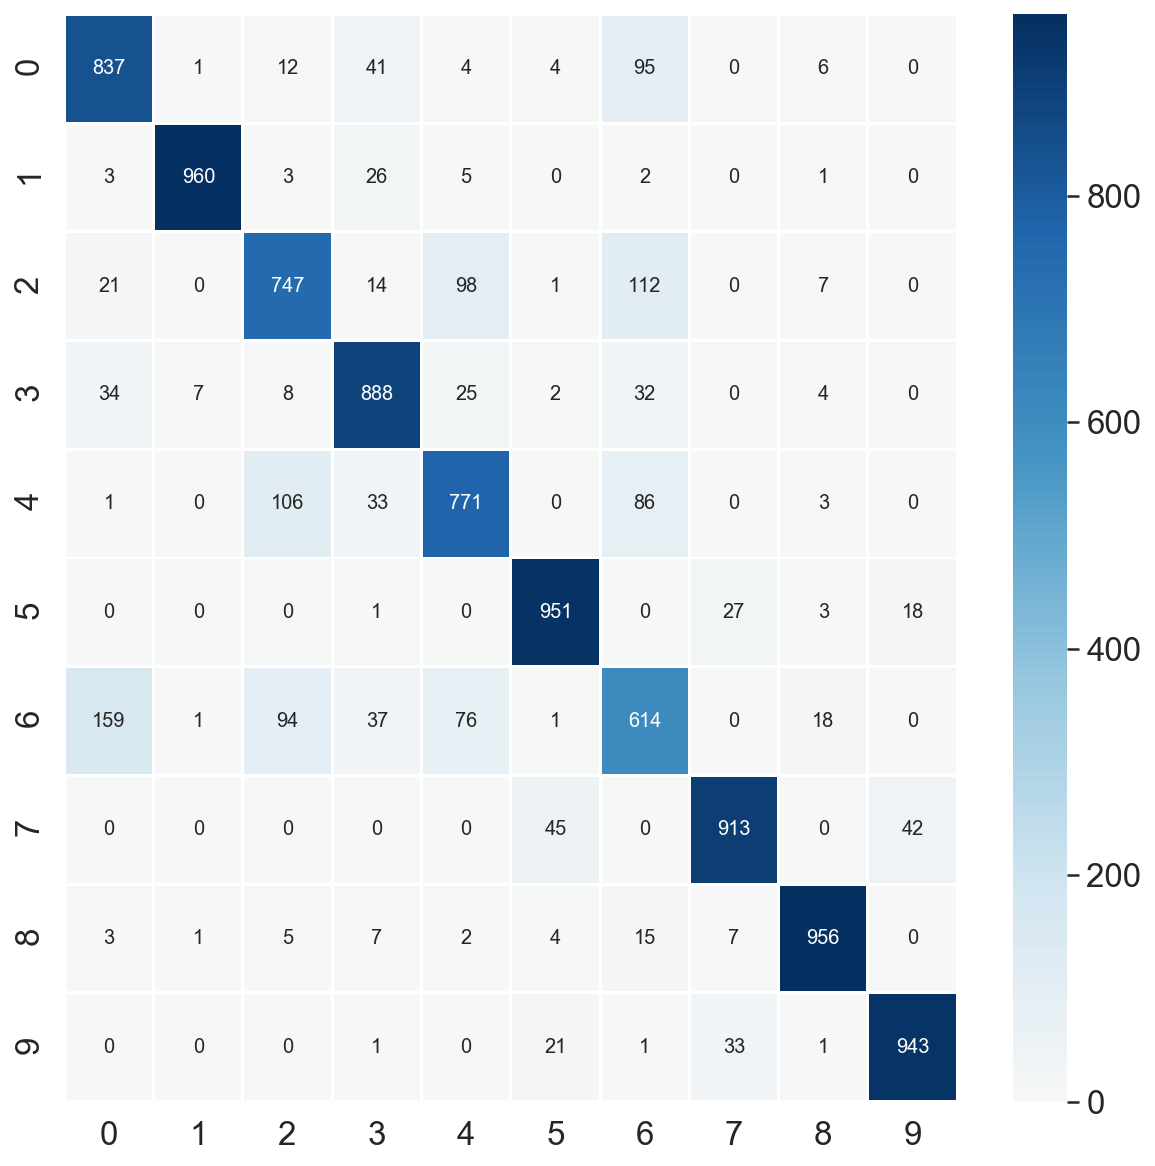

In [38]:
plt.figure(figsize=(10,10))
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, center=0, linewidth=1, fmt="d", annot=True,cmap="RdBu")

#### Calculating the value of Precision, Recall, Accuracy and F1 score

In [39]:
print(classification_report(y_test, predictions, labels=np.arange(0,10)))

              precision    recall  f1-score   support

           0       0.79      0.84      0.81      1000
           1       0.99      0.96      0.97      1000
           2       0.77      0.75      0.76      1000
           3       0.85      0.89      0.87      1000
           4       0.79      0.77      0.78      1000
           5       0.92      0.95      0.94      1000
           6       0.64      0.61      0.63      1000
           7       0.93      0.91      0.92      1000
           8       0.96      0.96      0.96      1000
           9       0.94      0.94      0.94      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



### Convolutional Neural Network

In [40]:
X_train, X_test, X_val = X_train.reshape(X_train.shape + (1,)), X_test.reshape(X_test.shape + (1,)), X_val.reshape(X_val.shape + (1,))

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(48000, 28, 28, 1)
(10000, 28, 28, 1)
(12000, 28, 28, 1)


#### Declaring the hyperparameters

In [41]:
import time
dense_layers = [1,2]
layer_sizes = [32,64]
conv_layers = [1,2]

#### Training the Deep Neural Network

In [42]:
histories = {}
for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            model_ckeckpoint = tf.keras.callbacks.ModelCheckpoint(filepath="{}-nodes-{}-dense-{}-conv.h5".format(layer_size, dense_layer, conv_layer), monitor="val_loss",verbose=1,save_best_only=True, save_weights_only=True)
            model = Sequential()
            model.add(Conv2D(layer_size, (3,3), input_shape = X_train.shape[1:]))
            model.add(Activation("relu"))
            model.add(MaxPool2D(pool_size=(2,2)))
            for l in range(conv_layer-1):
                model.add(Conv2D(layer_size, (3,3), input_shape = X_train.shape[1:]))
                model.add(Activation("relu"))
                model.add(MaxPool2D(pool_size=(2,2)))
            for l in range(dense_layer):
                model.add(Dense(layer_size))
                model.add(Activation("relu"))
            model.add(Flatten())
            model.add(Dense(10))
            model.add(Activation(activation="softmax"))
            model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics = ["accuracy"])
            history = model.fit(X_train, y_train, batch_size=2048, validation_data=(X_val, y_val), callbacks=[model_ckeckpoint], epochs=10)
            histories["{}-nodes-{}-dense-{}-conv".format(layer_size, dense_layer,conv_layer)] = history

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
47104/48000 [============================>.] - ETA: 0s - loss: 1.5285 - accuracy: 0.5808
Epoch 00001: val_loss improved from inf to 0.83047, saving model to 32-nodes-1-dense-1-conv.h5
48000/48000 [==============================] - 14s 282us/sample - loss: 1.5157 - accuracy: 0.5838 - val_loss: 0.8305 - val_accuracy: 0.7308
Epoch 2/10
47104/48000 [============================>.] - ETA: 0s - loss: 0.6984 - accuracy: 0.7612
Epoch 00002: val_loss improved from 0.83047 to 0.62193, saving model to 32-nodes-1-dense-1-conv.h5
48000/48000 [==============================] - 14s 289us/sample - loss: 0.6970 - accuracy: 0.7613 - val_loss: 0.6219 - val_accuracy: 0.7791
Epoch 3/10
47104/48000 [============================>.] - ETA: 0s - loss: 0.5623 - accuracy: 0.8039
Epoch 00003: val_loss improved from 0.62193 to 0.52386, saving model to 32-nodes-1-dense-1-conv.h5
48000/48000 [==============================] - 13s 263us/sample - loss: 0.561

Epoch 5/10
47104/48000 [============================>.] - ETA: 0s - loss: 0.4001 - accuracy: 0.8603
Epoch 00005: val_loss improved from 0.42405 to 0.39447, saving model to 64-nodes-1-dense-1-conv.h5
48000/48000 [==============================] - 25s 522us/sample - loss: 0.3996 - accuracy: 0.8608 - val_loss: 0.3945 - val_accuracy: 0.8597
Epoch 6/10
47104/48000 [============================>.] - ETA: 0s - loss: 0.3743 - accuracy: 0.8689
Epoch 00006: val_loss improved from 0.39447 to 0.36732, saving model to 64-nodes-1-dense-1-conv.h5
48000/48000 [==============================] - 28s 588us/sample - loss: 0.3742 - accuracy: 0.8686 - val_loss: 0.3673 - val_accuracy: 0.8677
Epoch 7/10
47104/48000 [============================>.] - ETA: 0s - loss: 0.3585 - accuracy: 0.8742
Epoch 00007: val_loss improved from 0.36732 to 0.34887, saving model to 64-nodes-1-dense-1-conv.h5
48000/48000 [==============================] - 24s 503us/sample - loss: 0.3576 - accuracy: 0.8745 - val_loss: 0.3489 - val_

47104/48000 [============================>.] - ETA: 0s - loss: 0.3560 - accuracy: 0.8760
Epoch 00009: val_loss improved from 0.36495 to 0.35796, saving model to 32-nodes-2-dense-1-conv.h5
48000/48000 [==============================] - 16s 331us/sample - loss: 0.3557 - accuracy: 0.8762 - val_loss: 0.3580 - val_accuracy: 0.8725
Epoch 10/10
47104/48000 [============================>.] - ETA: 0s - loss: 0.3465 - accuracy: 0.8781
Epoch 00010: val_loss improved from 0.35796 to 0.35225, saving model to 32-nodes-2-dense-1-conv.h5
48000/48000 [==============================] - 15s 311us/sample - loss: 0.3459 - accuracy: 0.8783 - val_loss: 0.3522 - val_accuracy: 0.8743
Train on 48000 samples, validate on 12000 samples
Epoch 1/10
47104/48000 [============================>.] - ETA: 0s - loss: 1.8809 - accuracy: 0.3926
Epoch 00001: val_loss improved from inf to 1.08400, saving model to 32-nodes-2-dense-2-conv.h5
48000/48000 [==============================] - 21s 427us/sample - loss: 1.8667 - accura

Epoch 3/10
47104/48000 [============================>.] - ETA: 0s - loss: 0.6182 - accuracy: 0.7701
Epoch 00003: val_loss improved from 0.66704 to 0.56291, saving model to 64-nodes-2-dense-2-conv.h5
48000/48000 [==============================] - 42s 880us/sample - loss: 0.6172 - accuracy: 0.7704 - val_loss: 0.5629 - val_accuracy: 0.7871
Epoch 4/10
47104/48000 [============================>.] - ETA: 0s - loss: 0.5355 - accuracy: 0.8041
Epoch 00004: val_loss improved from 0.56291 to 0.49470, saving model to 64-nodes-2-dense-2-conv.h5
48000/48000 [==============================] - 39s 807us/sample - loss: 0.5355 - accuracy: 0.8042 - val_loss: 0.4947 - val_accuracy: 0.8148
Epoch 5/10
47104/48000 [============================>.] - ETA: 0s - loss: 0.4770 - accuracy: 0.8277
Epoch 00005: val_loss improved from 0.49470 to 0.45332, saving model to 64-nodes-2-dense-2-conv.h5
48000/48000 [==============================] - 38s 798us/sample - loss: 0.4760 - accuracy: 0.8281 - val_loss: 0.4533 - val_

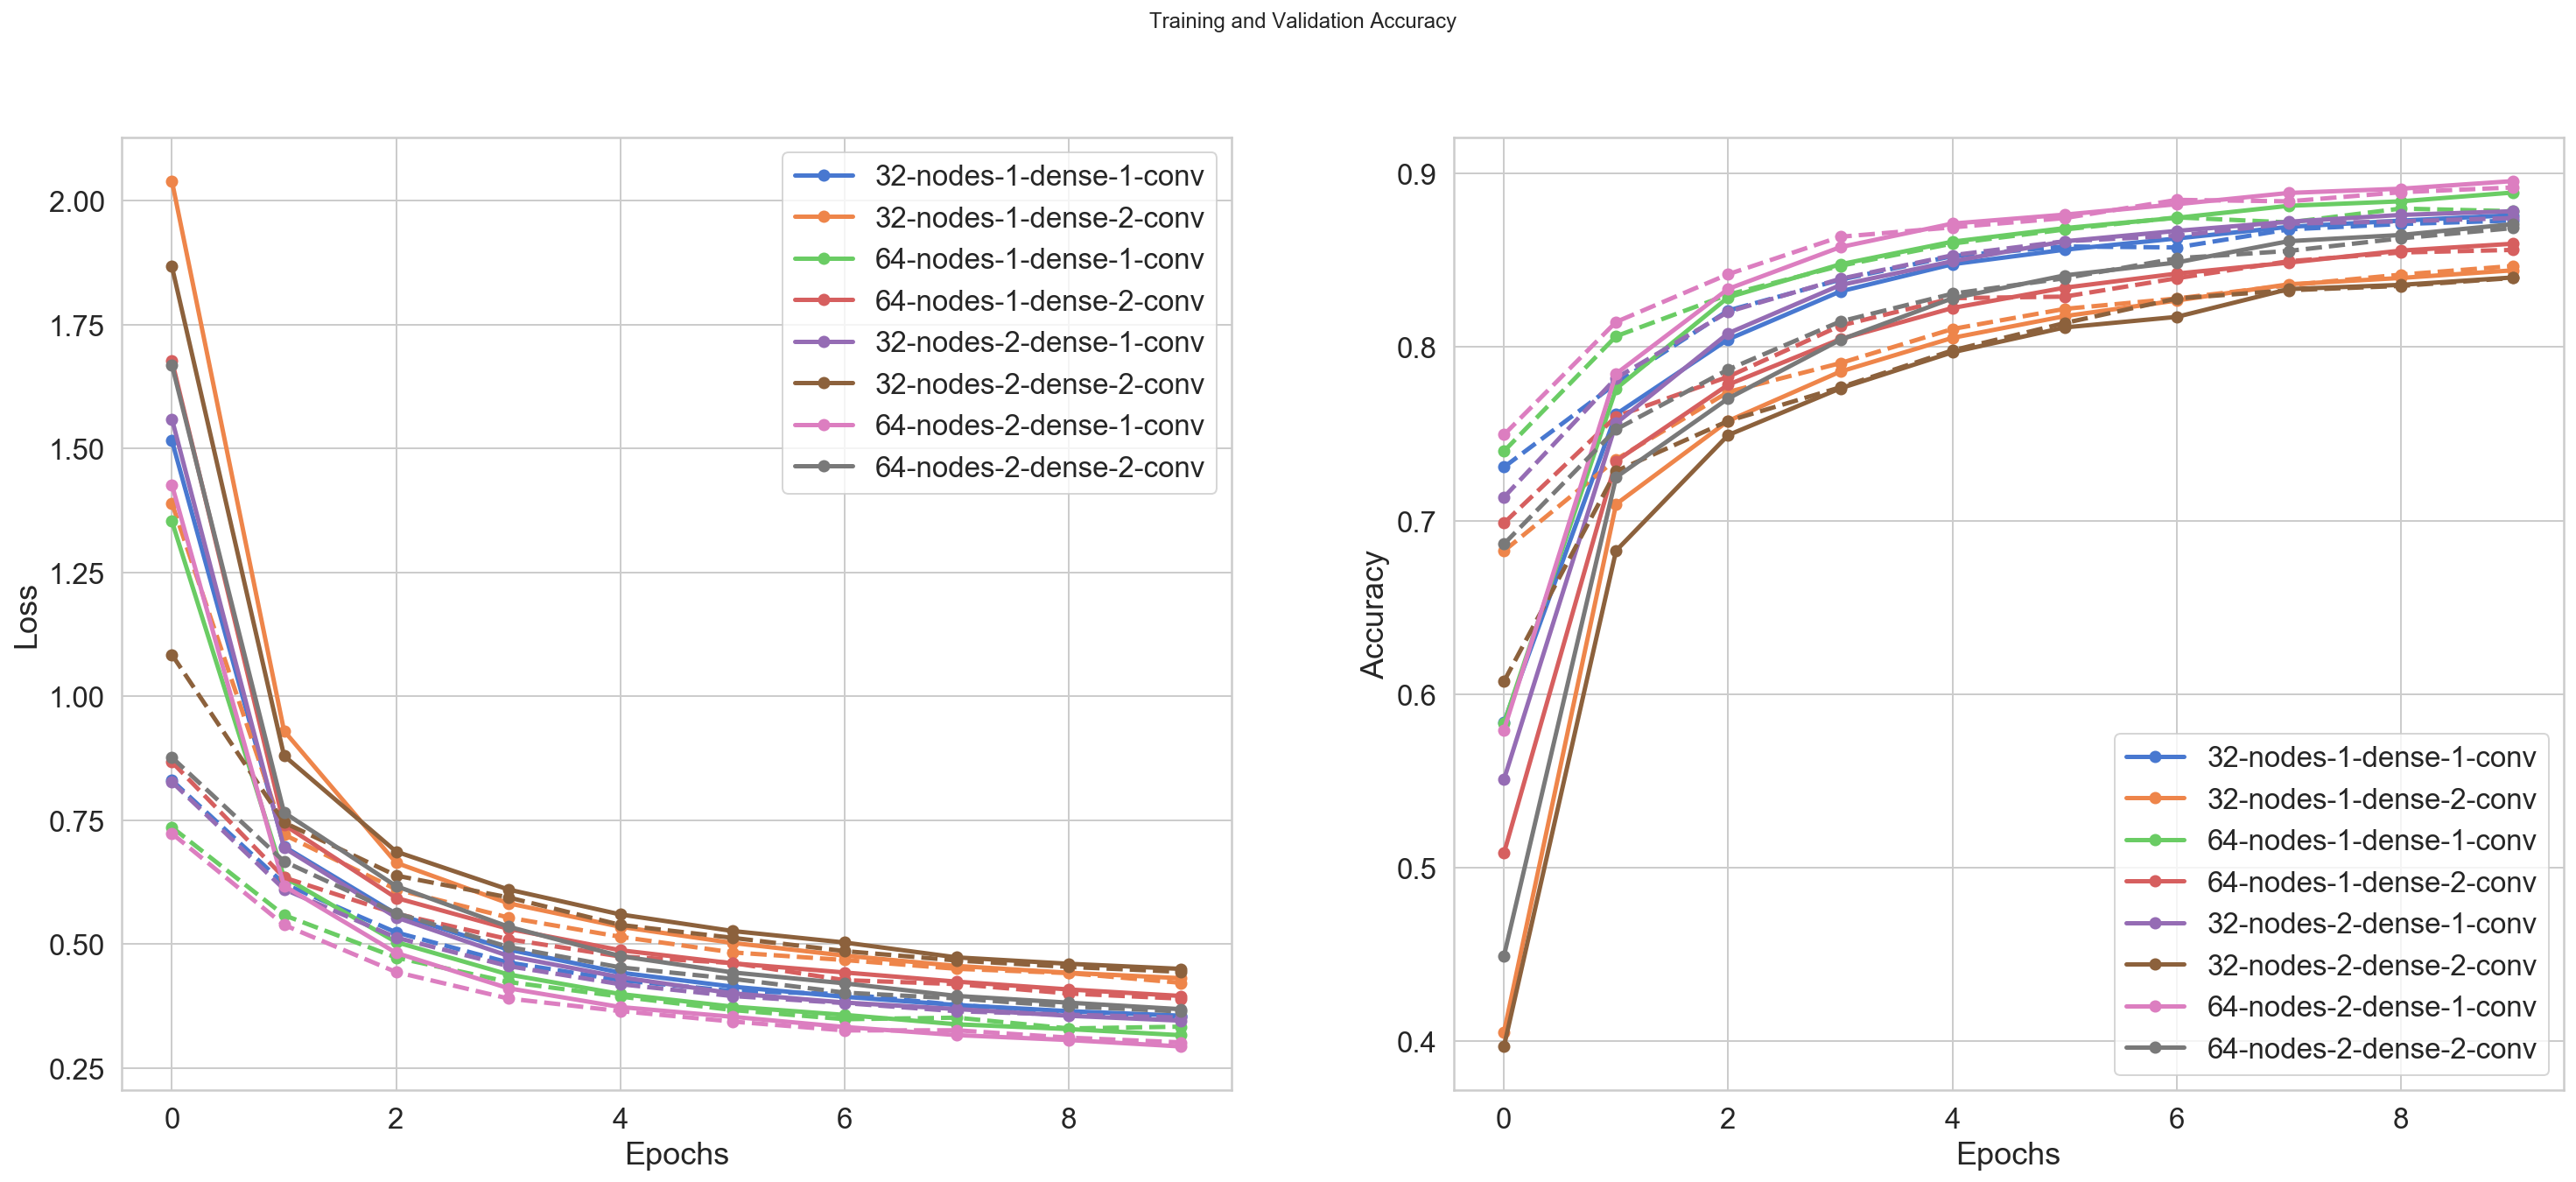

In [43]:
key = list(histories.keys())
plt.figure(figsize=(25,10))
for i in key:
    plot_histories(histories[i],i)

#### Visualizing the Training Loss, Validation Loss, Training Accuracy, Validation Accuracy

In [44]:
max_val_accuracy = 0
model_name = None
for i in key:
    if histories[i].history["val_accuracy"][-1] > max_val_accuracy:
        max_val_acc = histories[i].history["val_accuracy"][-1]
        model_name = i

#### Choosing the best model

In [45]:
print(f"The best model hyperparameters is {model_name}") 

The best model hyperparameters is 64-nodes-2-dense-2-conv


In [46]:
model.load_weights(f"{model_name}.h5")

#### Loading the Test Data

In [47]:
loss, accuracy = model.evaluate(X_test, y_test, batch_size=1024, verbose=0)

In [48]:
for name, value in zip(model.metrics_names, (loss, accuracy)):
    print(name, ":", value)

loss : 0.38901960563659665
accuracy : 0.8592


In [49]:
pred = model.predict(X_test)

In [50]:
predictions = np.argmax(pred, axis=1)

#### Plotting the Predictions

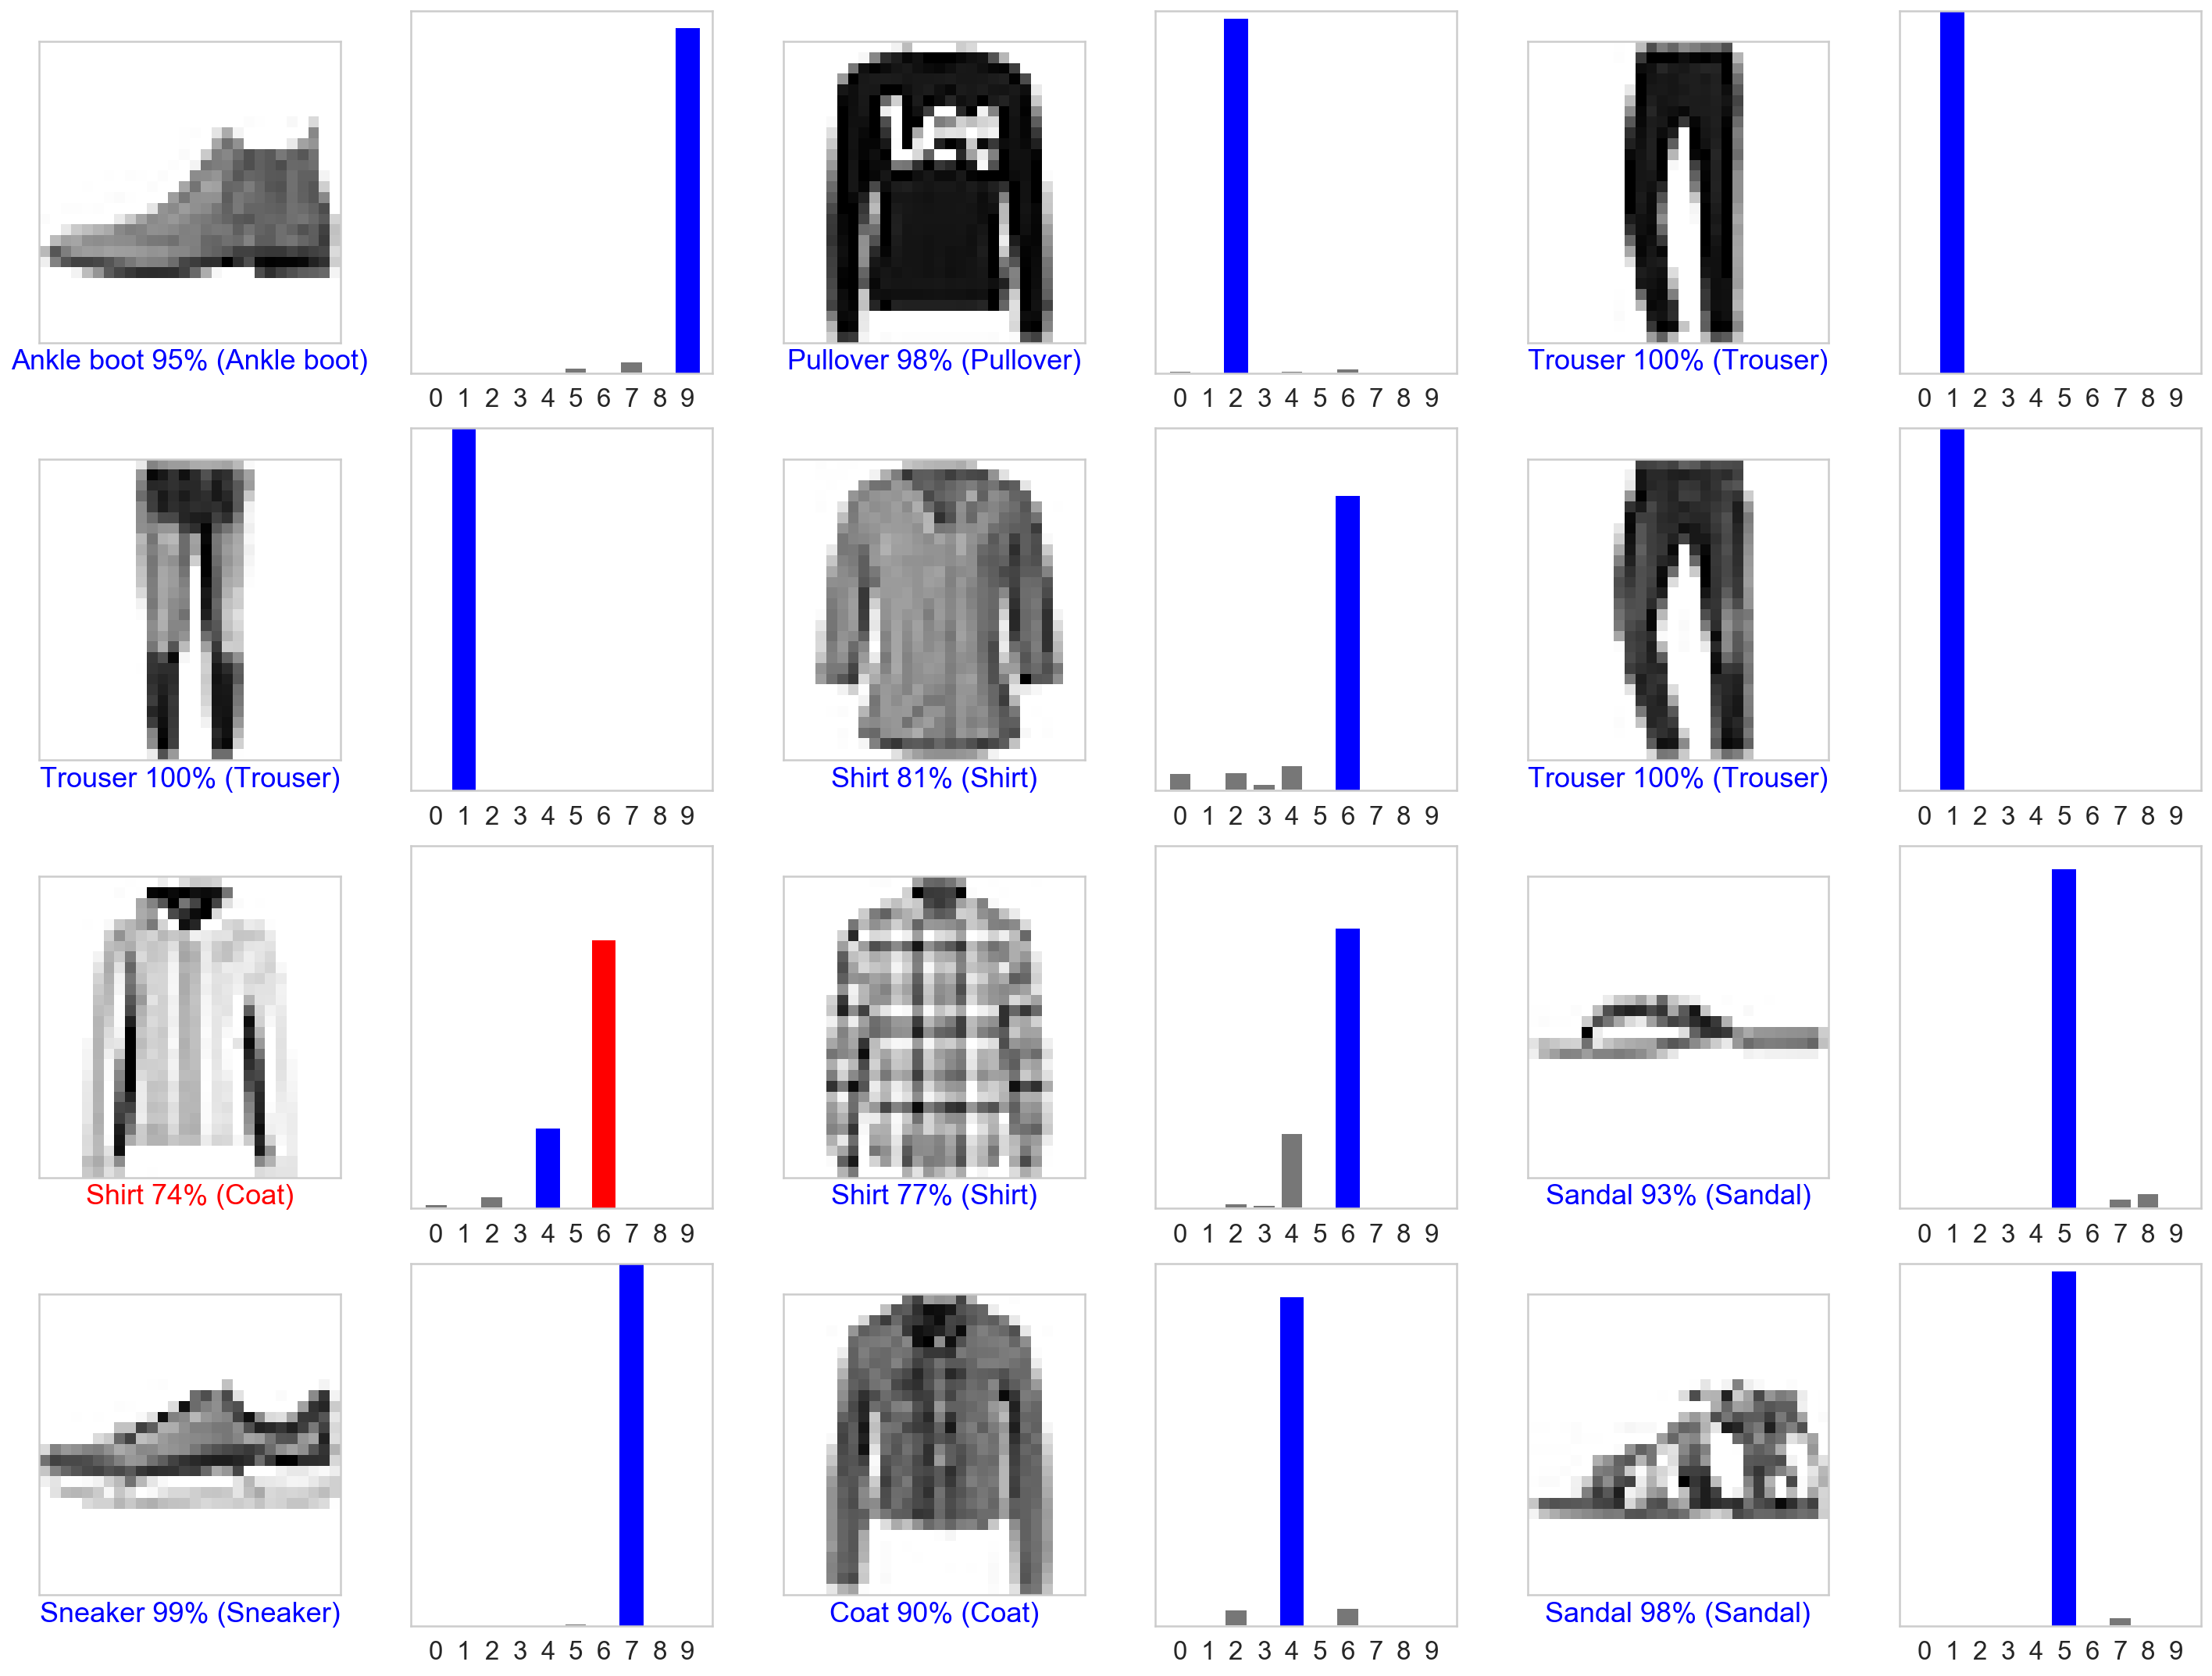

In [51]:
num_rows = 4
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(20, 15))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, pred[i], y_test, X_test.reshape(-1, 28, 28))
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, pred[i], y_test)
plt.tight_layout()
plt.show()

#### Classification Accuracy

In [52]:
print(f"The accuracy of the model is: {accuracy_score(predictions, y_test)*100}%")

The accuracy of the model is: 85.92%


#### Confusion Matrix

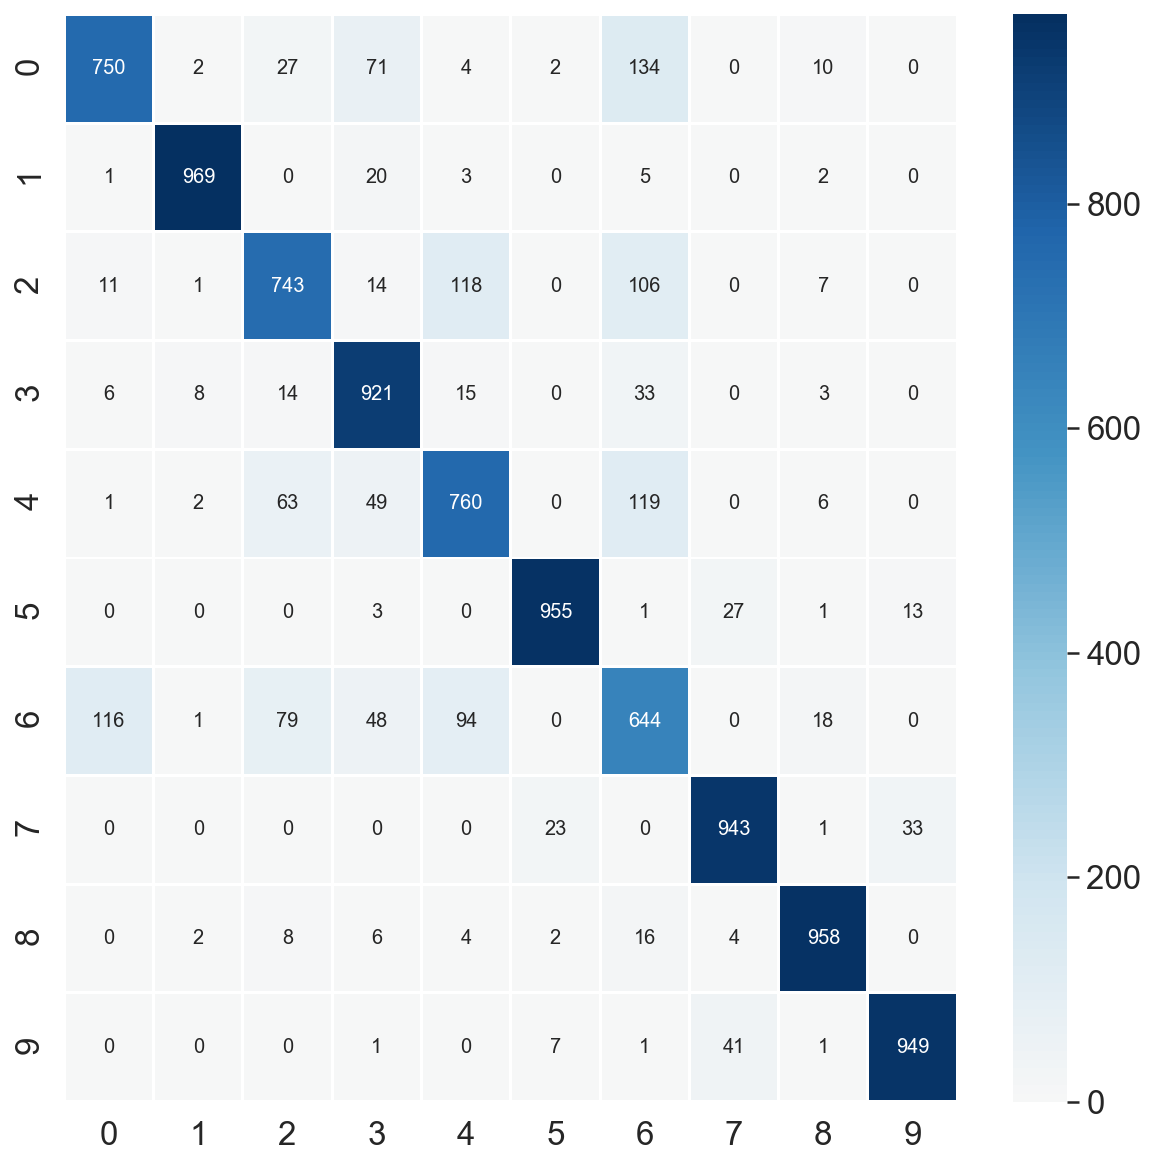

In [53]:
plt.figure(figsize=(10,10))
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, center=0, linewidth=1, fmt="d", annot=True,cmap="RdBu")

#### Calculating the value of Precision, Recall, Accuracy and F1 score

In [54]:
print(classification_report(y_test, predictions, labels=np.arange(0,10)))

              precision    recall  f1-score   support

           0       0.85      0.75      0.80      1000
           1       0.98      0.97      0.98      1000
           2       0.80      0.74      0.77      1000
           3       0.81      0.92      0.86      1000
           4       0.76      0.76      0.76      1000
           5       0.97      0.95      0.96      1000
           6       0.61      0.64      0.63      1000
           7       0.93      0.94      0.94      1000
           8       0.95      0.96      0.95      1000
           9       0.95      0.95      0.95      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

